## Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Заказчик этого исследования — сеть отелей `«Как в гостях»`. Для привлечения клиентов данная сеть отелей добавила на свой сайт возможность забронировать номер без внесения предоплаты. Однако при отмене бронирования компания терпела убытки.

**Цель проекта** — минимизировать возможные убытки компании.

**Задача проекта** — разработать систему, предсказывающую отказ от бронирования. Если модель определит, что бронь будет отменена, то клиенту предложат внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

*Источником данных* является история бронирования, предоставленная сетью отелей.

### Шаг 1. Изучение данных из файла

In [1]:
# загрузка библиотеки методов для анализа данных
!pip install --upgrade pip
!pip install sweetviz

In [2]:
# импорт библиотек и методов
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os
from pathlib import Path
import sweetviz as sv
import urllib.request

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

> Информация о бронированиях содержится в файлах `/datasets/hotel_train.csv` и  `/datasets/hotel_test.csv`, расположенных на *Яндекс.Диске*. Данные изначально разделены на *обучающую выборку* (первый файл) и на *тестовую выборку* (второй файл).

Чтобы не прилагать файл с данными каждый раз при отправке, напишем код, позволяющий прочитать файл с любого компьютера.

In [3]:
# создание папки 'datsets' в директории
Path('datasets').mkdir(parents=True, exist_ok=True)

# создание словаря с именем файла и ссылкой на него
urls = {
   'hotel_train': ('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/hwR65ekOcYMc4w', '/datasets/hotel_train.csv'),
    'hotel_test': ('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/_y8OFIud3Jll3Q','/datasets/hotel_test.csv'),
    
}

for url in urls:
# проверка наличия файла 
    if not os.path.exists(urls.get(url)[1]):
        print(urls.get(url)[1], 'файл не найден, будет загружен из сети')
# скачивание файла по ссылке url и размещение файла по пути file_name
        urllib.request.urlretrieve(*urls.get(url))
     
df =  pd.read_csv(urls[url][1])

In [4]:
# чтение файлов и вывод первых пяти строк каждого файла
tables = ['/datasets/hotel_train.csv', '/datasets/hotel_test.csv']
for table in tables:
    df = pd.read_csv(table)
    display(df.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


Запишем каждую таблицу в отдельный файл.

In [5]:
# запись таблиц в отдельные файлы
df_train, df_test = pd.read_csv('/datasets/hotel_train.csv'), pd.read_csv('/datasets/hotel_test.csv')
# вывод таблицы для проверки 
display(df_train.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


**Исходные данные:**

В таблицах `hotel_train` и `hotel_test` содержатся одинаковые столбцы:

* *id* — номер записи;
* *adults* — количество взрослых постояльцев;
* *arrival_date_year* — год заезда;
* *arrival_date_month* — месяц заезда;
* *arrival_date_week_number* — неделя заезда;
* *arrival_date_day_of_month* — день заезда;
* *babies* — количество младенцев;
* *booking_changes* — количество изменений параметров заказа;
* *children* — количество детей от 3 до 14 лет;
* *country* — гражданство постояльца;
* *customer_type* — тип заказчика:
* *Contract* — договор с юридическим лицом;
* *Group* — групповой заезд;
* *Transient* — не связано с договором или групповым заездом;
* *Transient-party* — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
* *days_in_waiting_list* — сколько дней заказ ожидал подтверждения;
* *distribution_channel* — канал дистрибуции заказа;
* *is_canceled* — отмена заказа;
* *is_repeated_guest* — признак того, что гость бронирует номер второй раз;
* *lead_time* — количество дней между датой бронирования и датой прибытия;
* *meal* — опции заказа:
SC — нет дополнительных опций;
BB — включён завтрак;
HB — включён завтрак и обед;
FB — включён завтрак, обед и ужин.
* *previous_bookings_not_canceled* — количество подтверждённых заказов у клиента;
* *previous_cancellations* — количество отменённых заказов у клиента;
* *required_car_parking_spaces* — необходимость места для автомобиля;
* *reserved_room_type* — тип забронированной комнаты;
* *stays_in_weekend_nights* — количество ночей в выходные дни;
* *stays_in_week_nights* — количество ночей в будние дни;
* *total_nights* — общее количество ночей;
* *total_of_special_requests* — количество специальных отметок.

Будем использовать библиотеку *sweetviz* для возможности выявления проблем в исходных данных.

                                             |          | [  0%]   00:00 -> (? left)


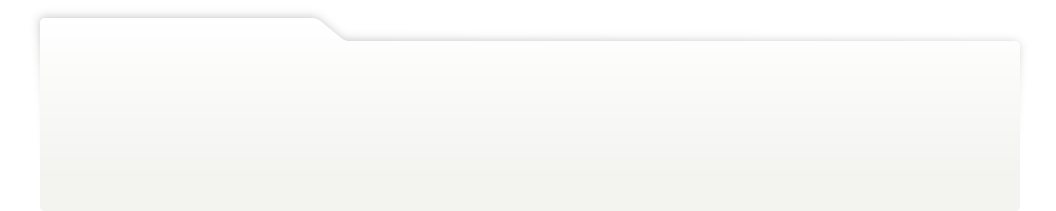
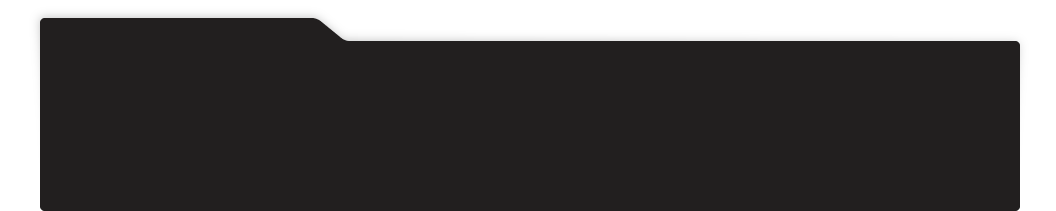
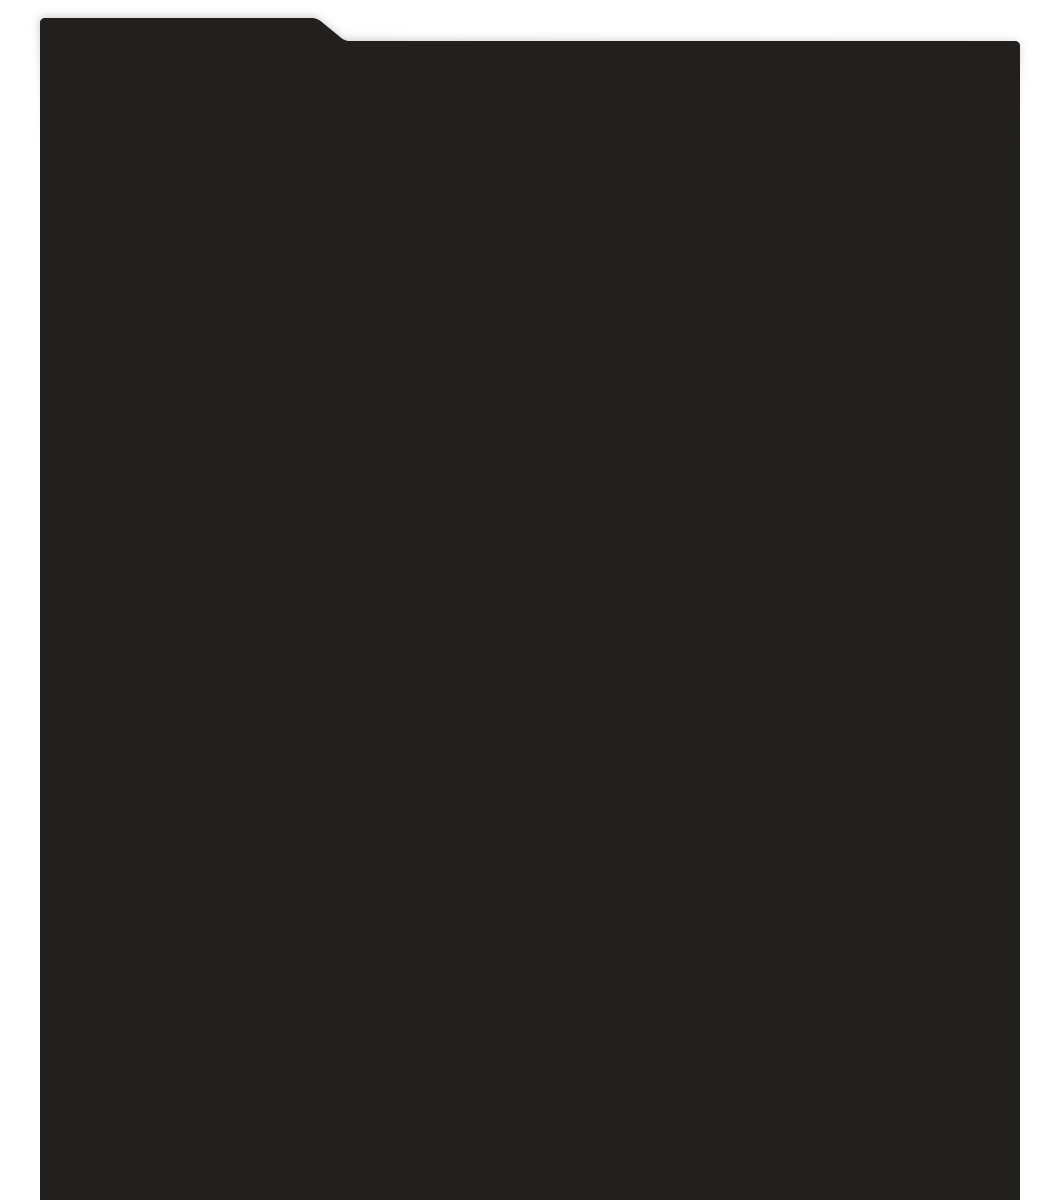
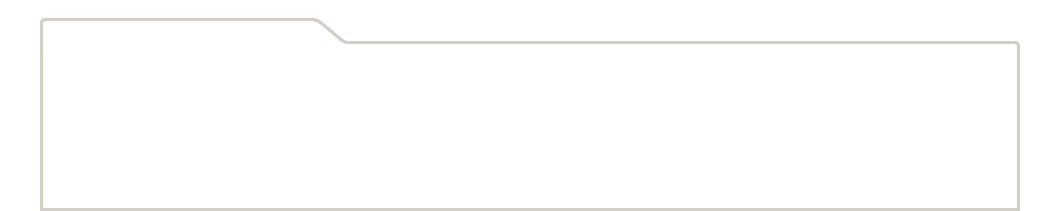
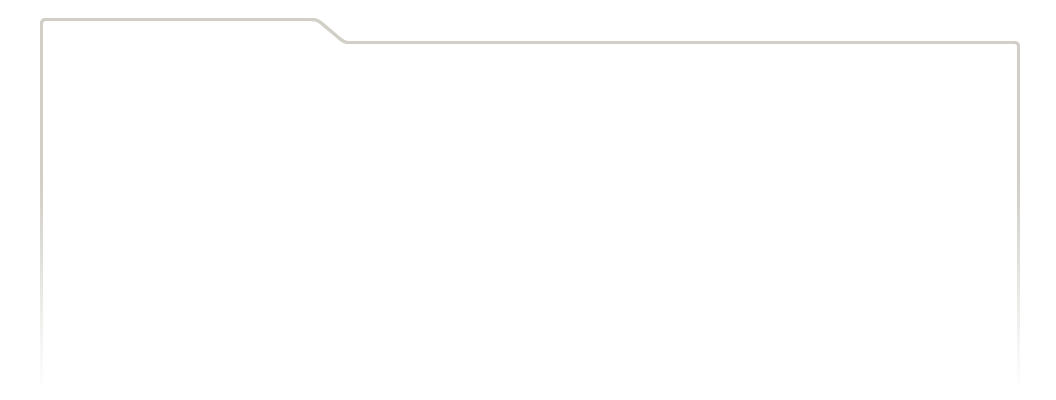
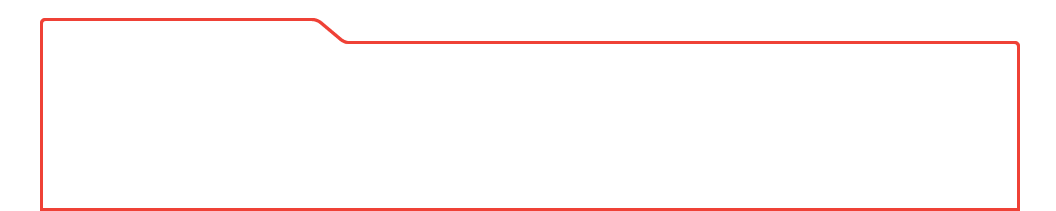
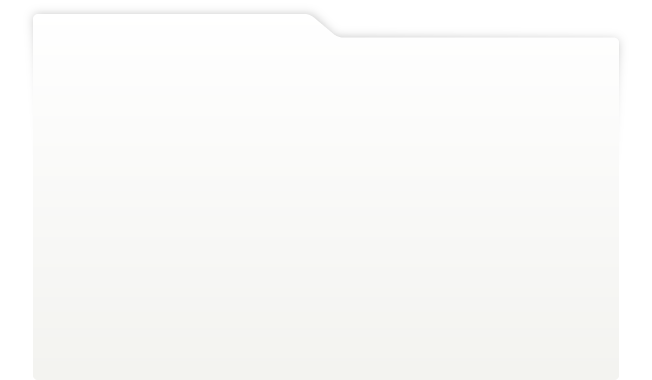
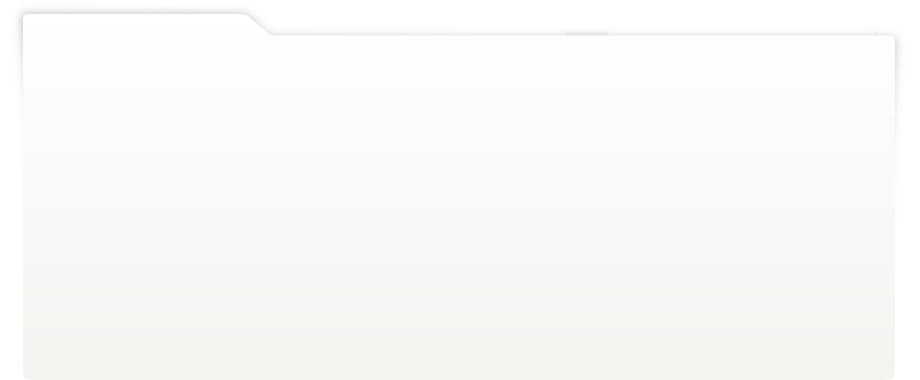
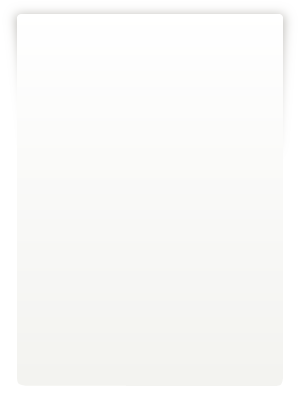
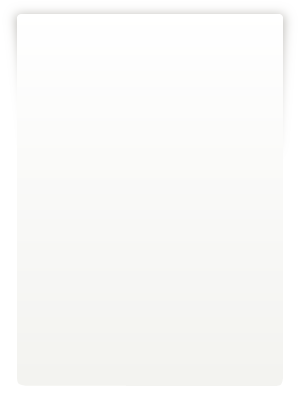
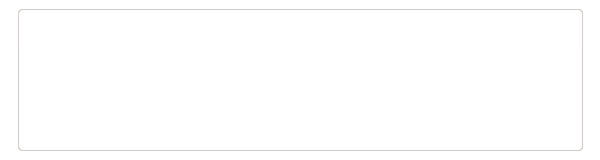
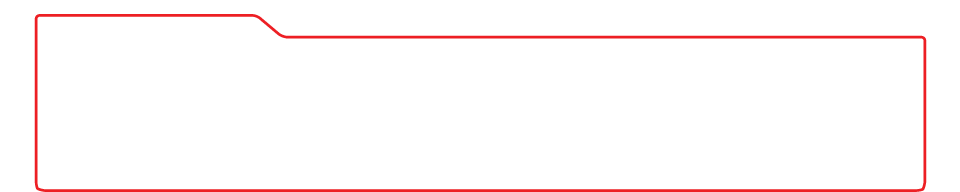
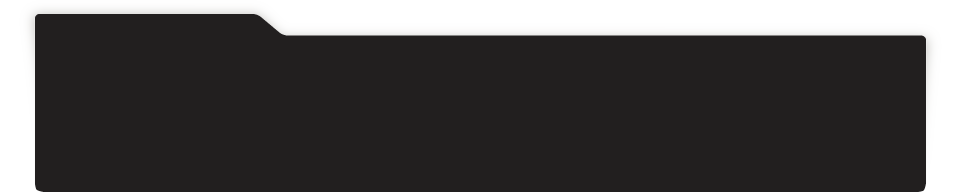
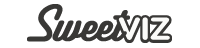
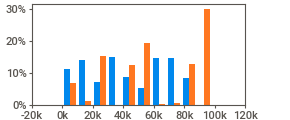
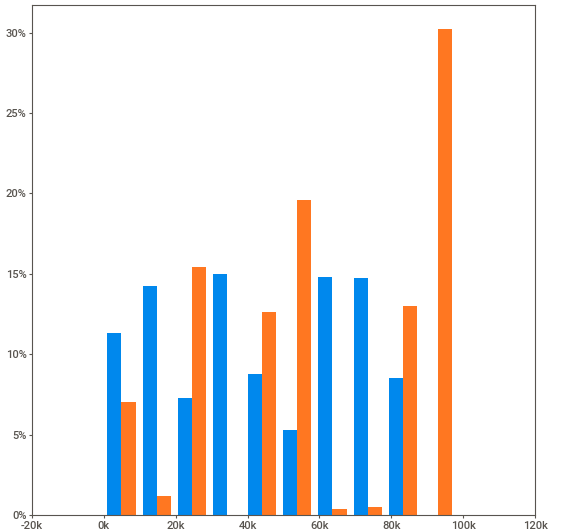
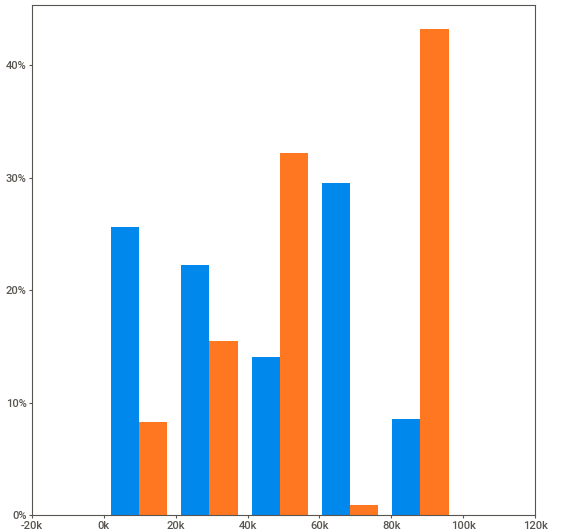
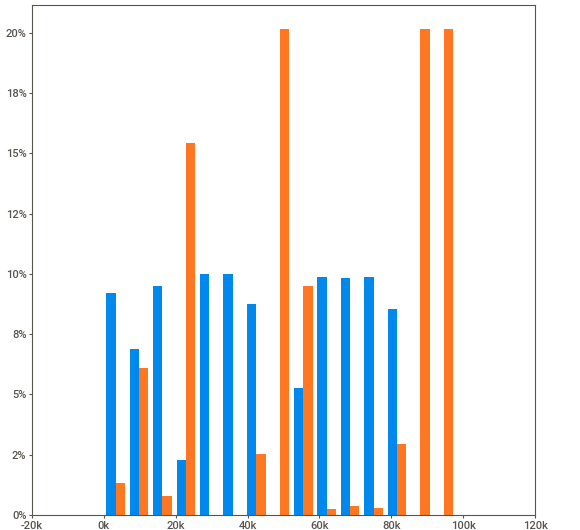
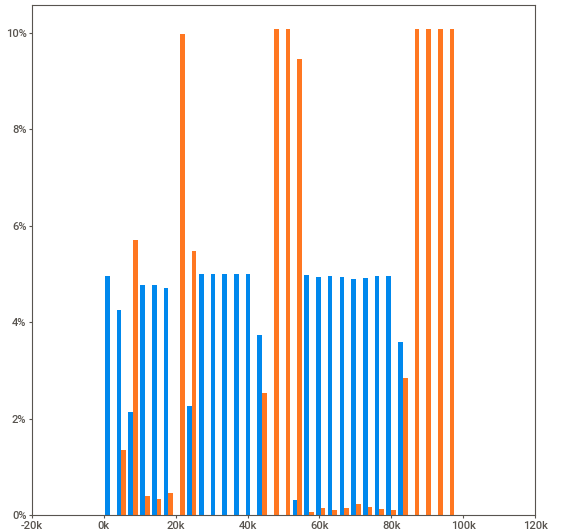
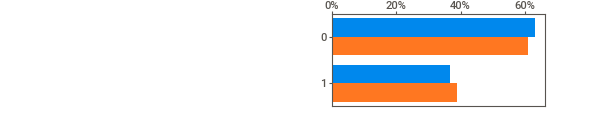
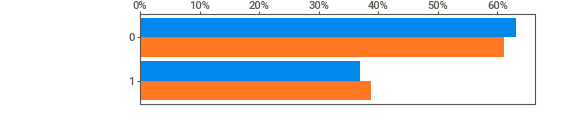
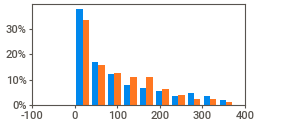
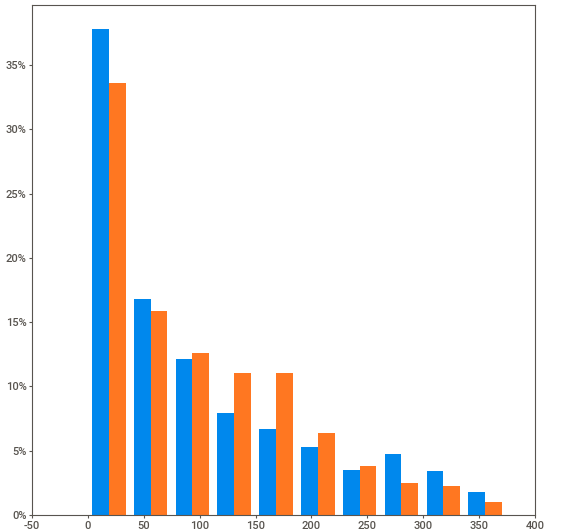
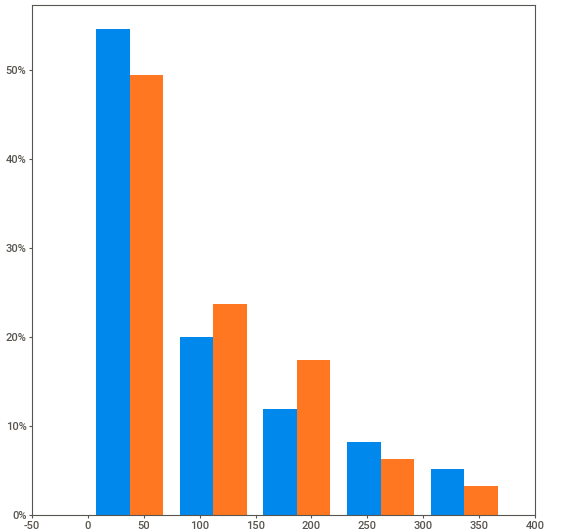
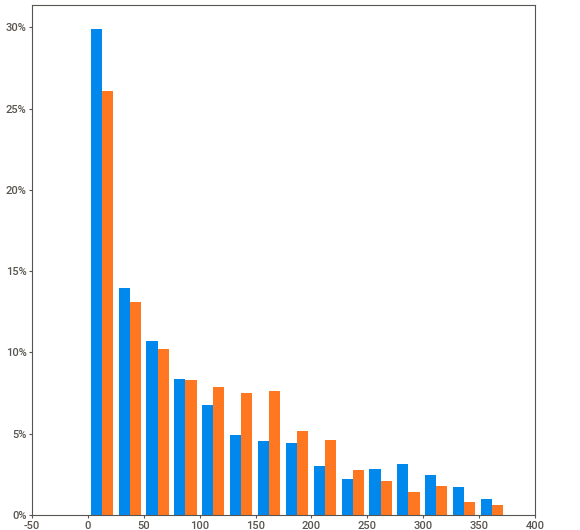
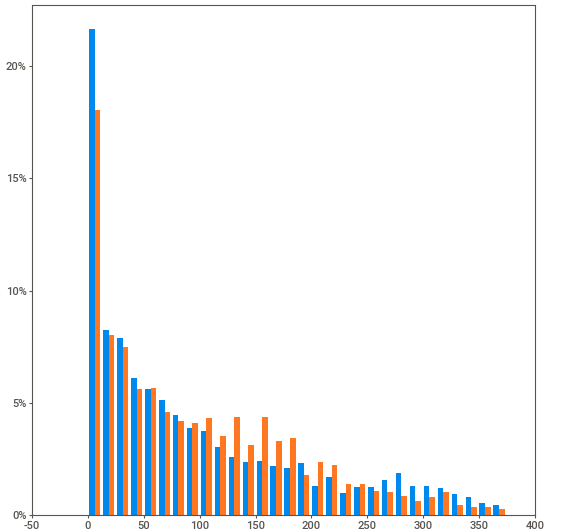
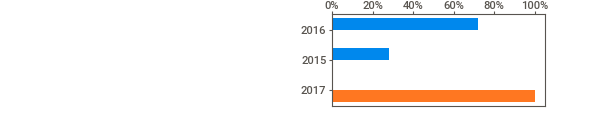
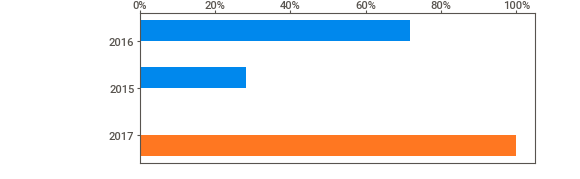
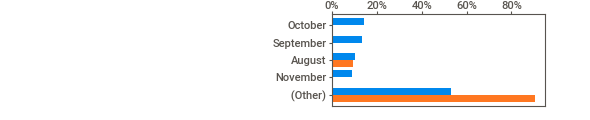
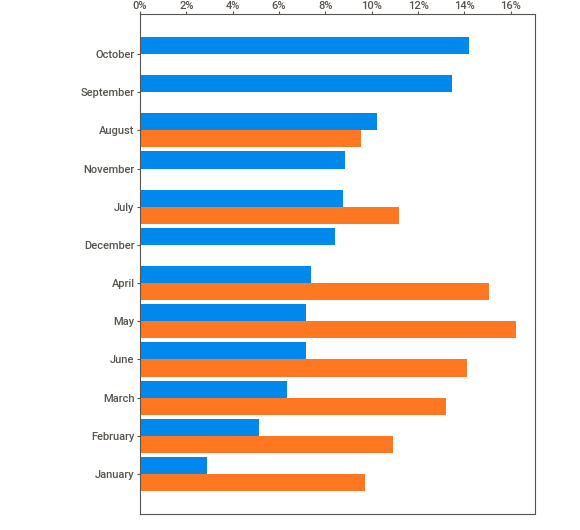
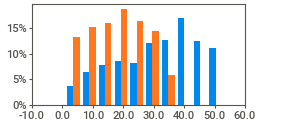
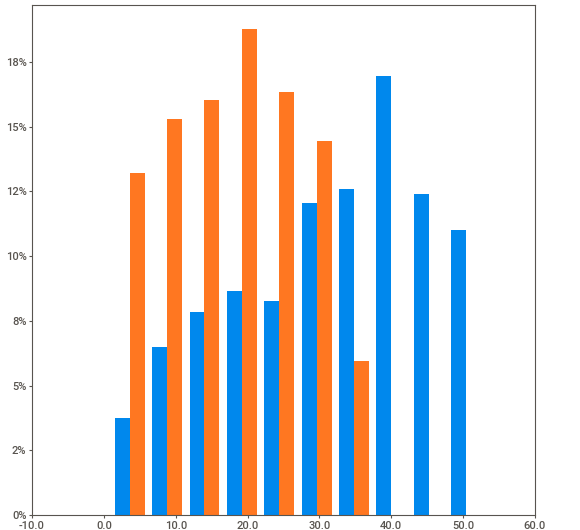
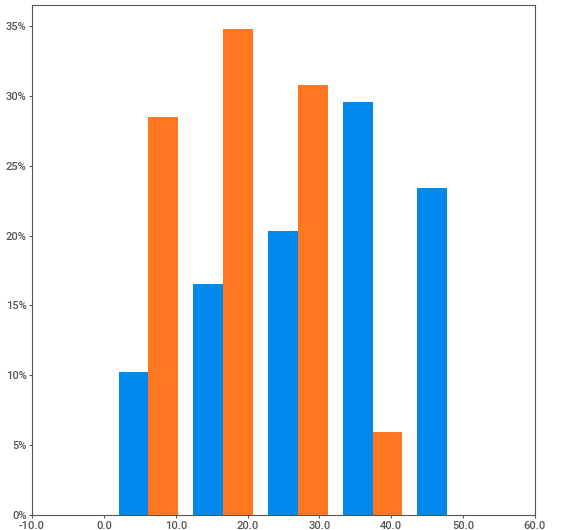
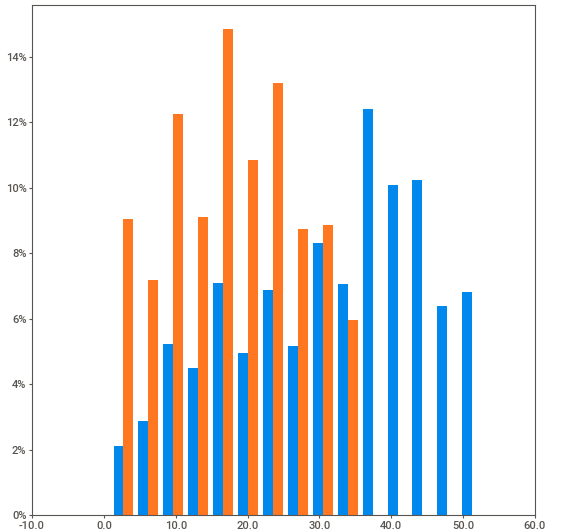
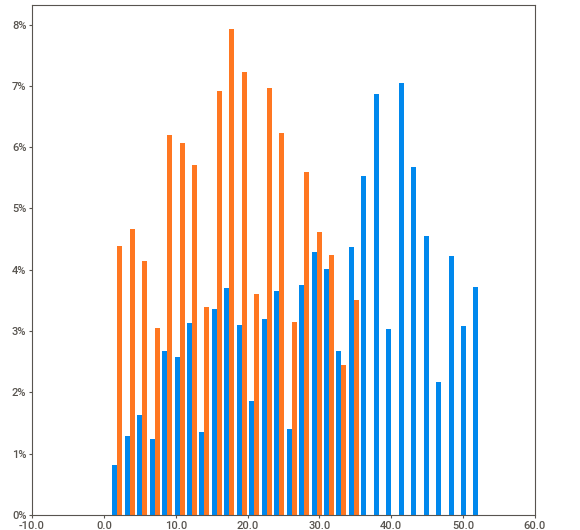
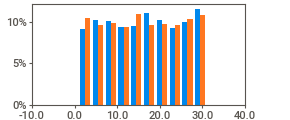
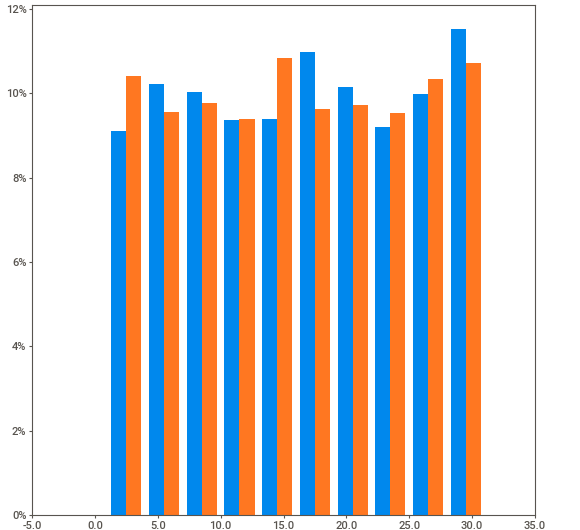
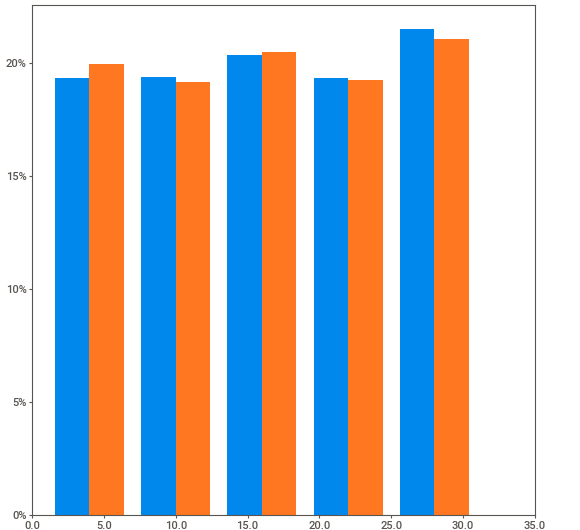
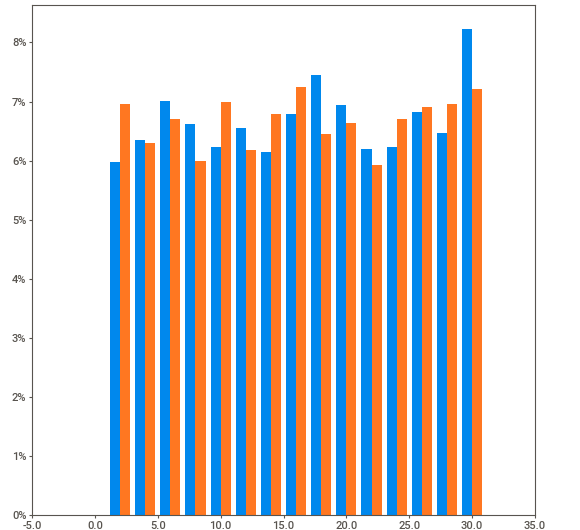
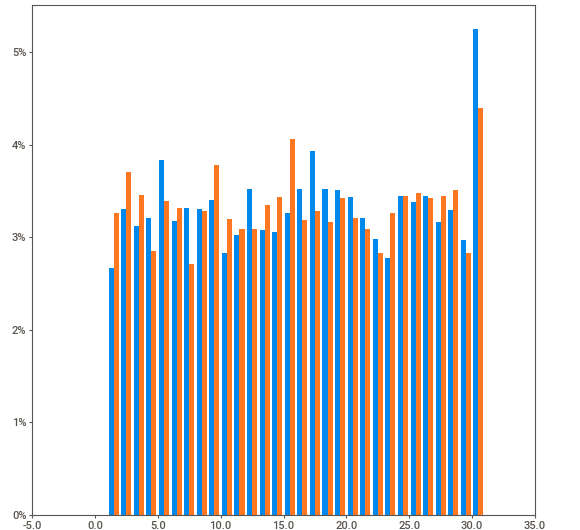
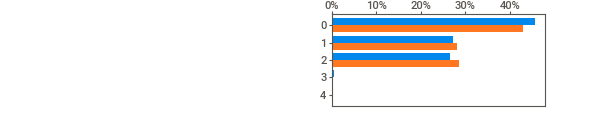
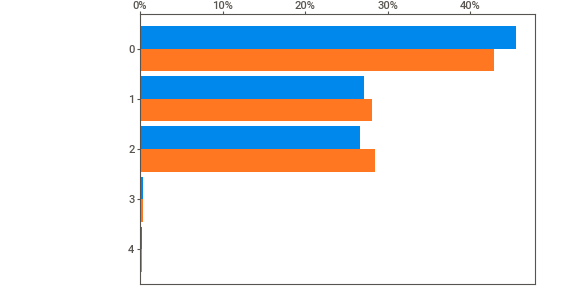
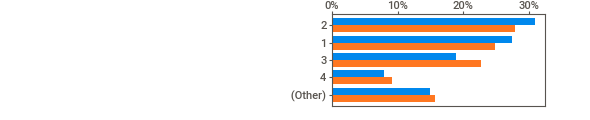
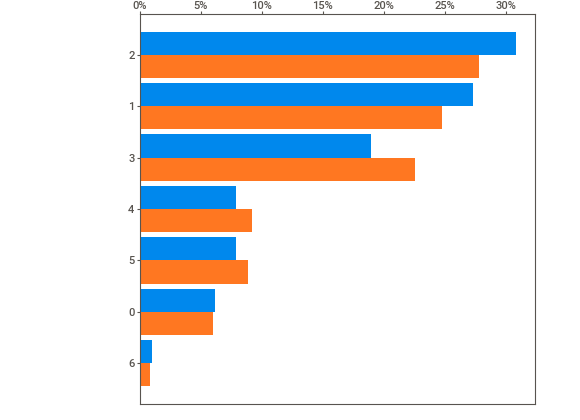
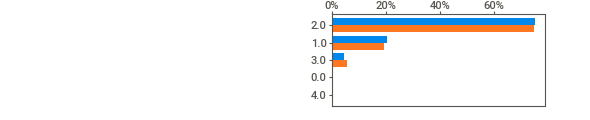
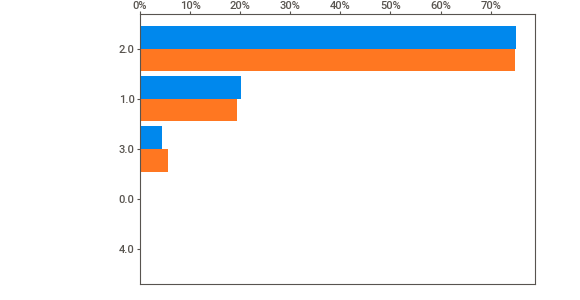
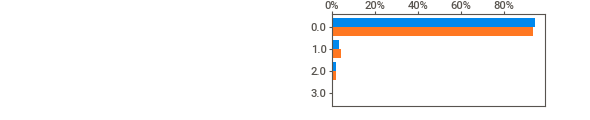
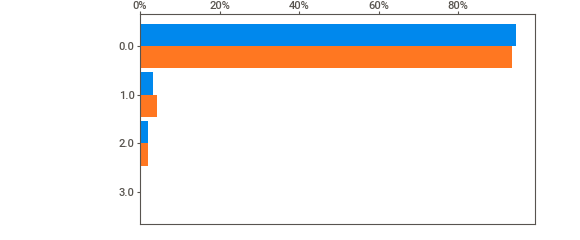
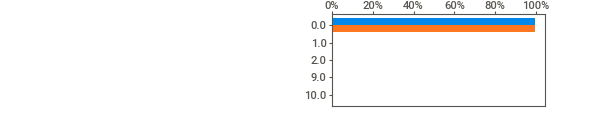
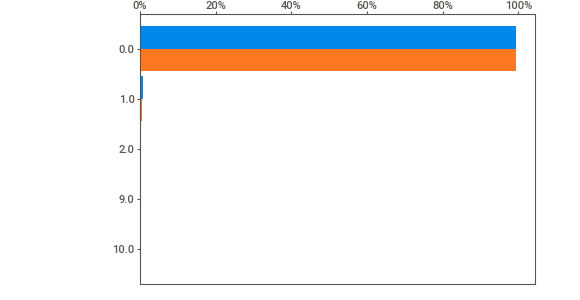
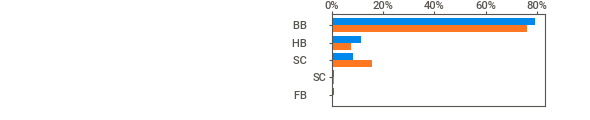
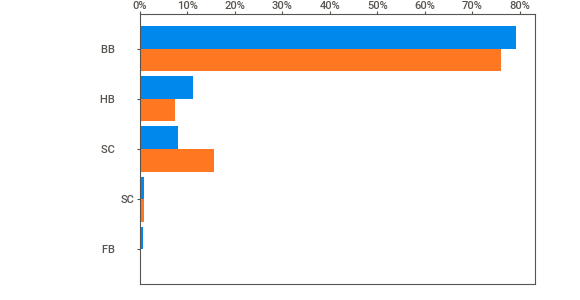
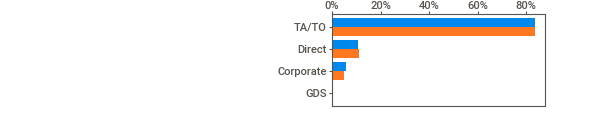
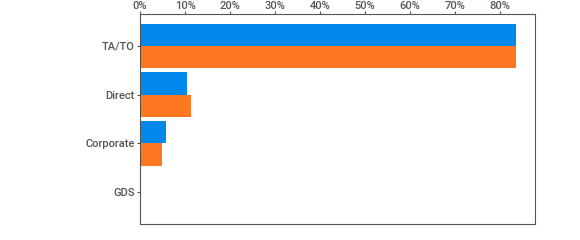
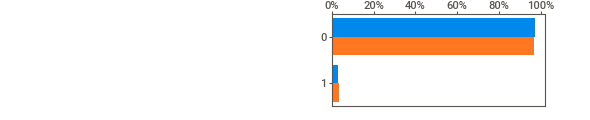
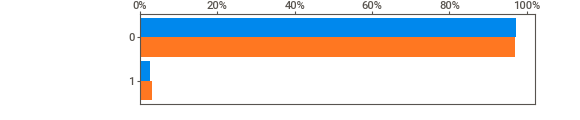
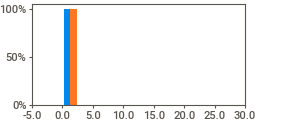
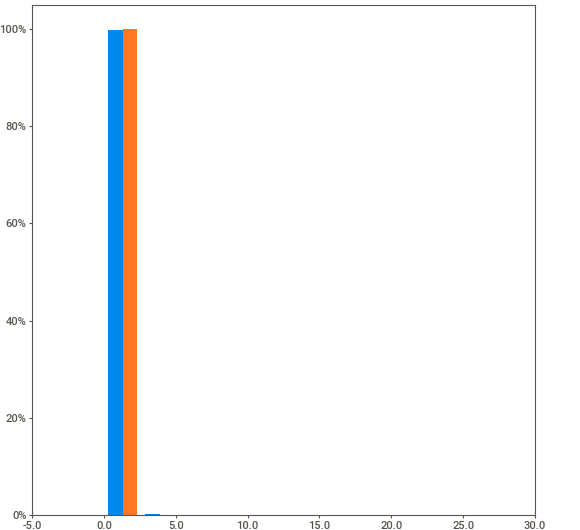
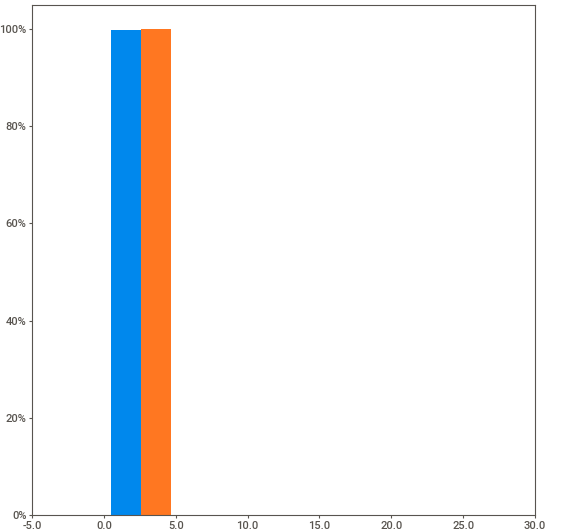
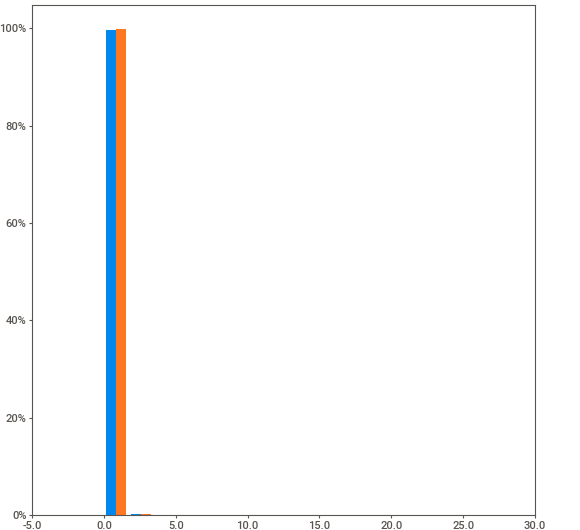
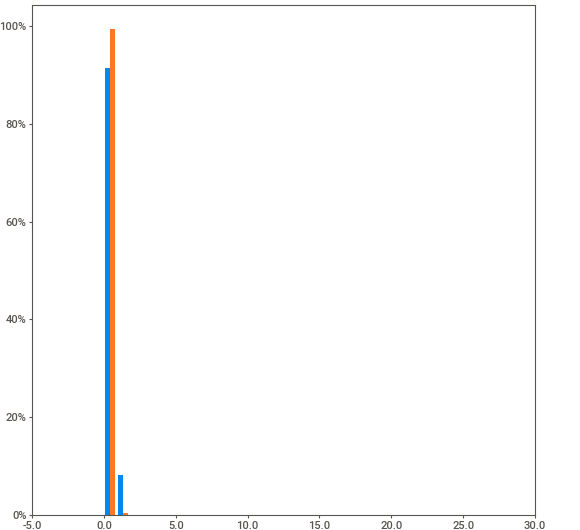
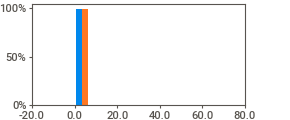
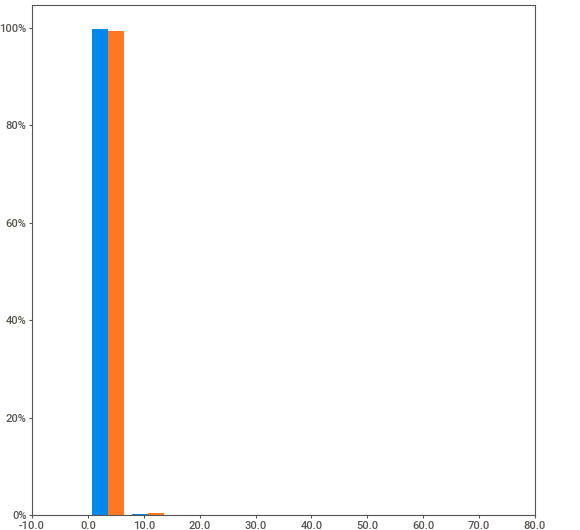
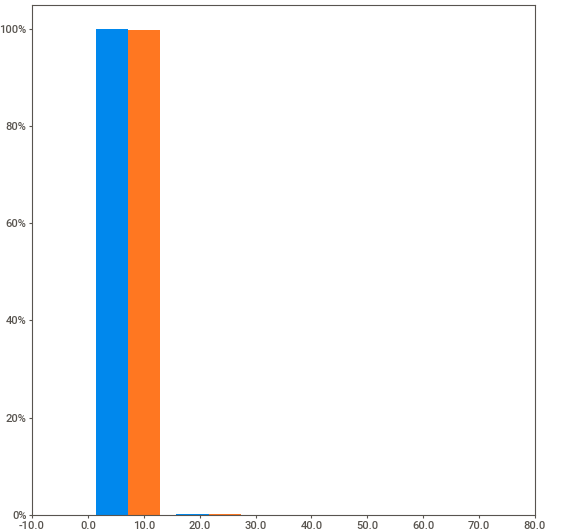
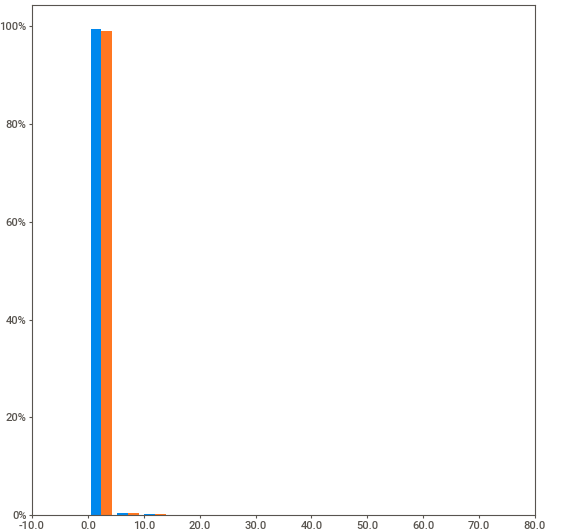
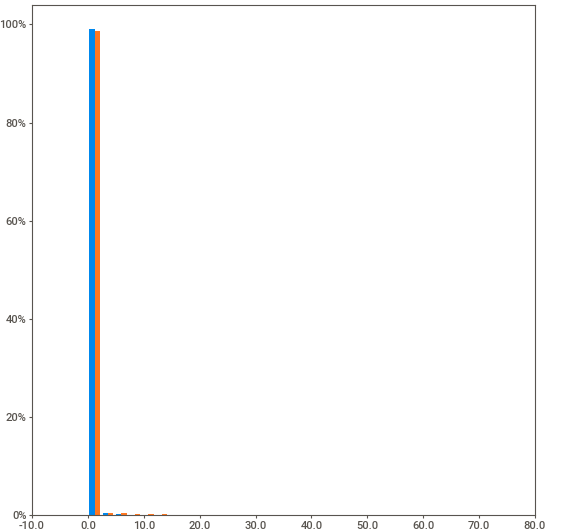
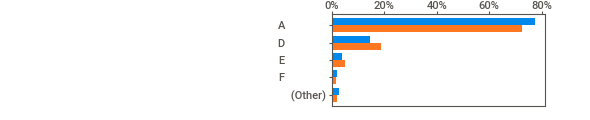
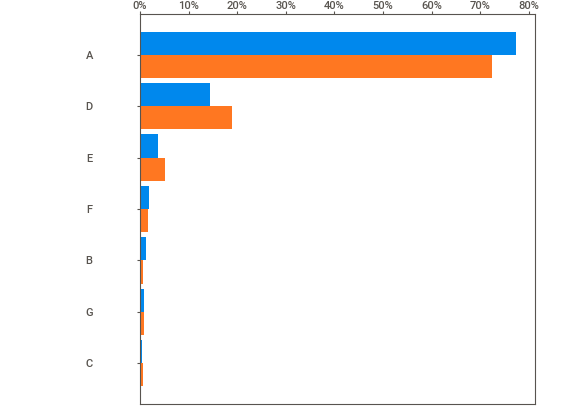
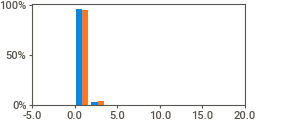
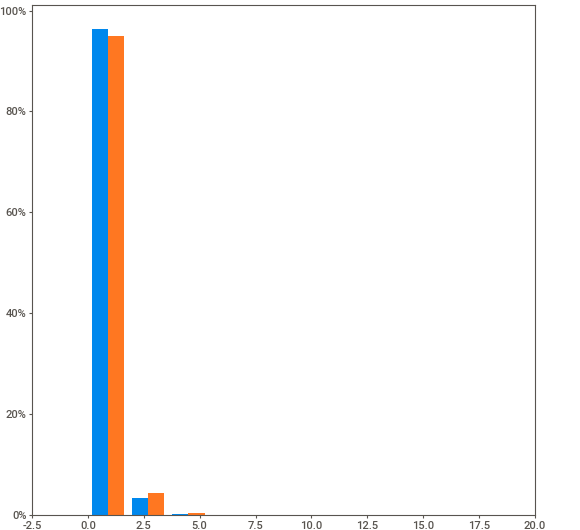
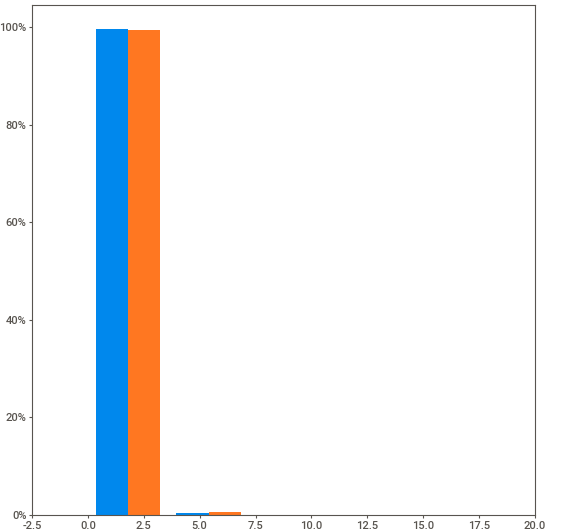
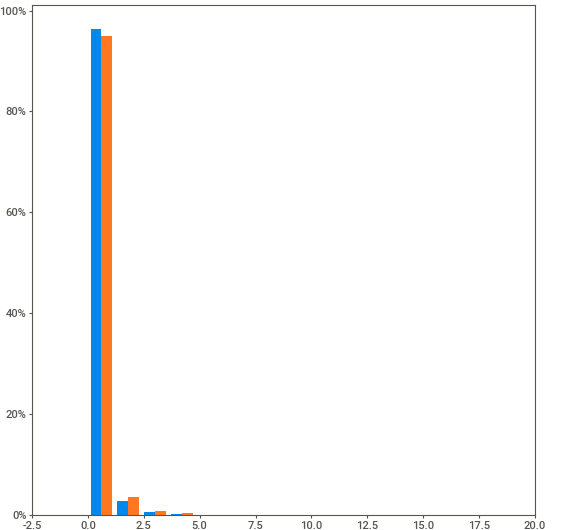
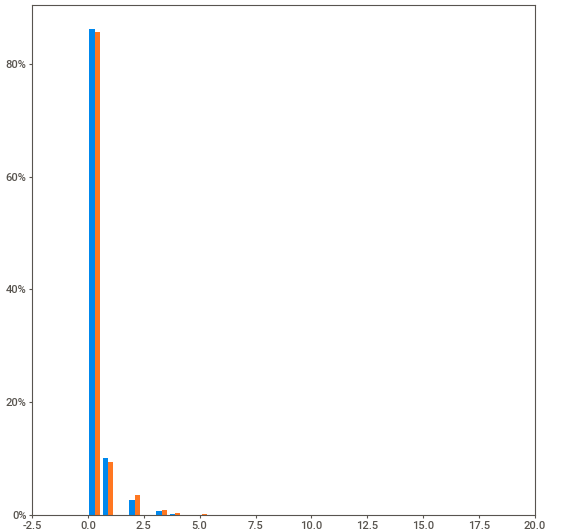
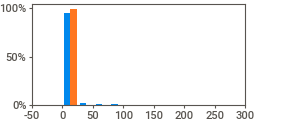
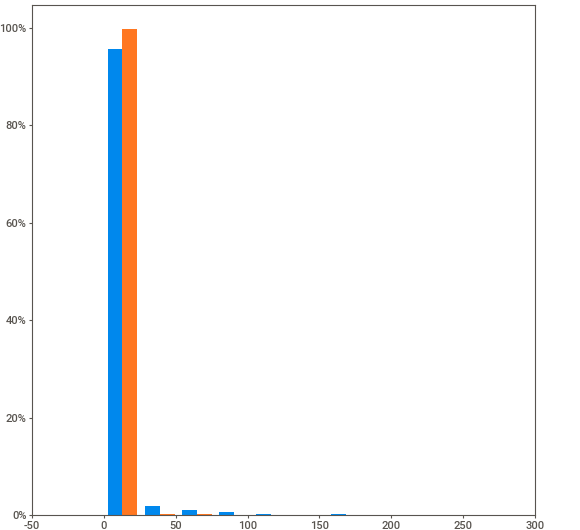
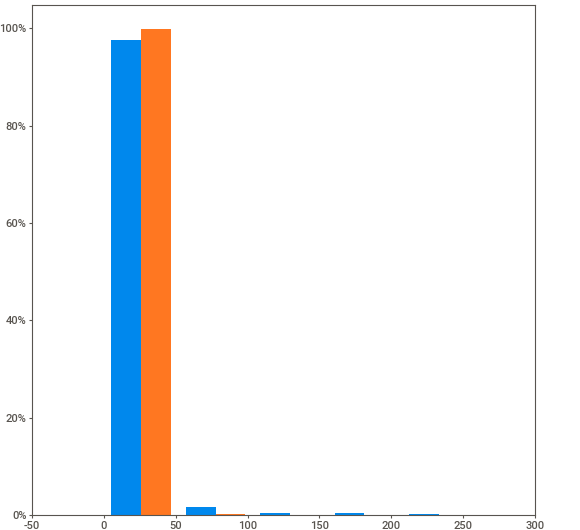
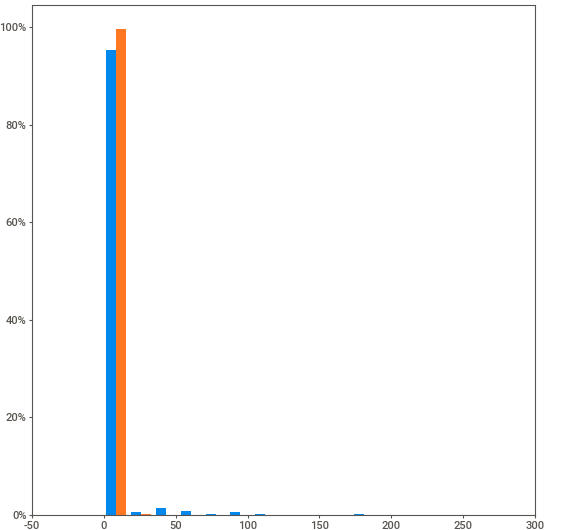
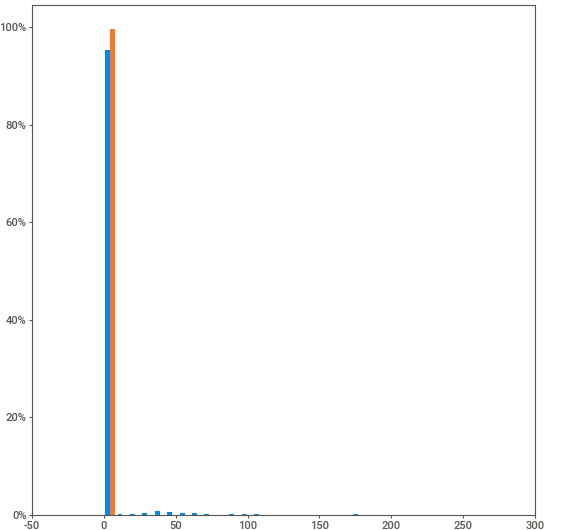
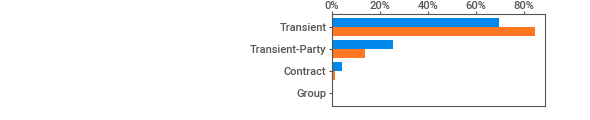
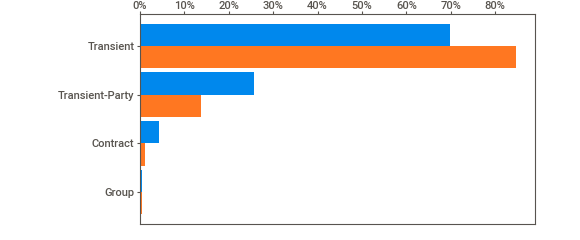
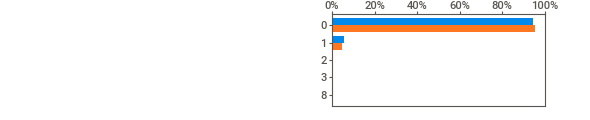
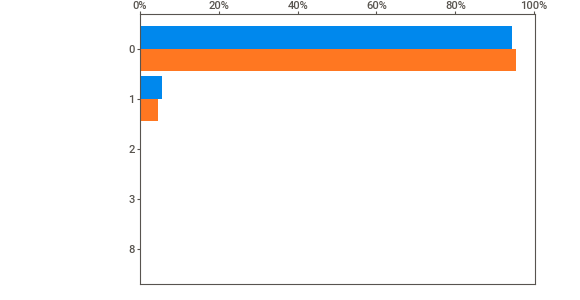
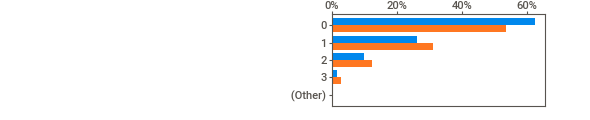
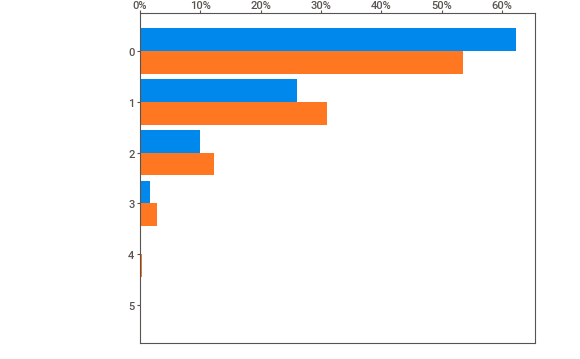
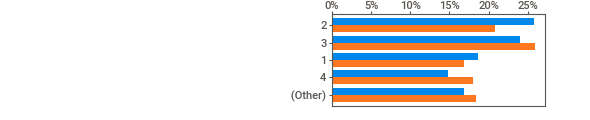
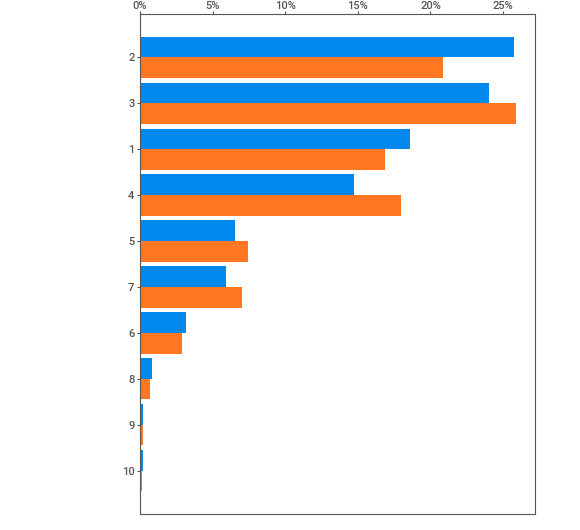
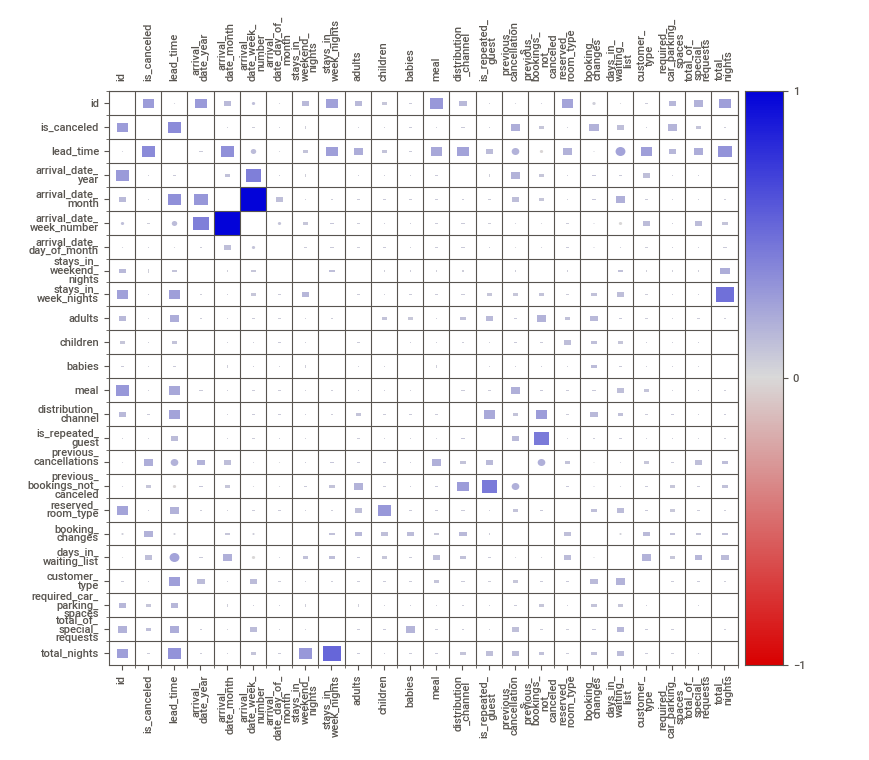
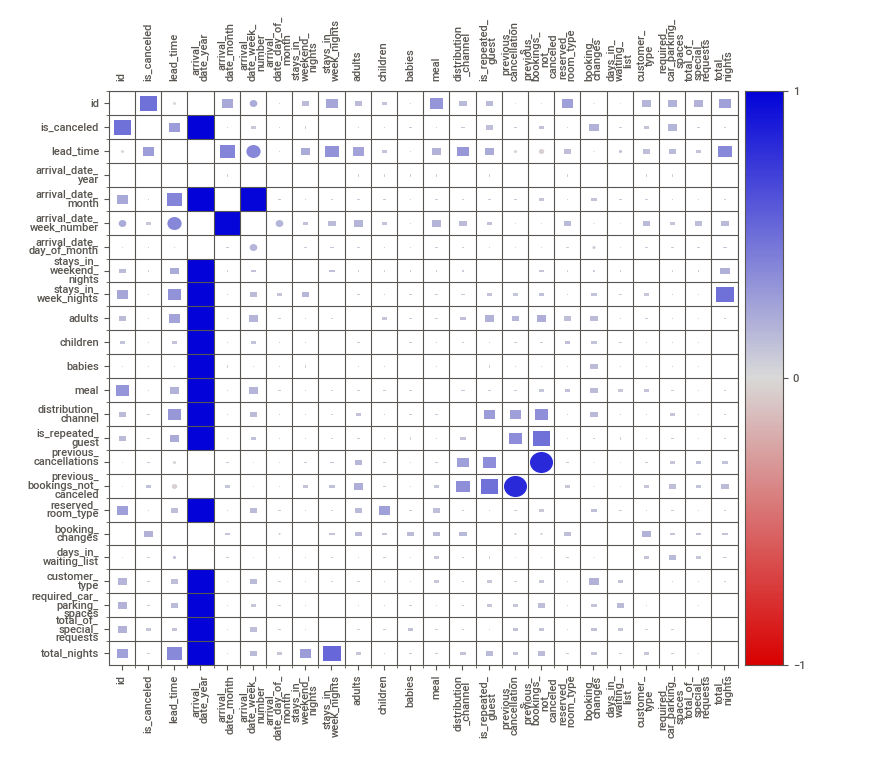

In [6]:
# вывод аналитической сводки данных для двух исходных таблиц
report = sv.compare([df_train, 'hotel_train'], [df_test, 'hotel_test'])
report.show_notebook(w=1500, h=500)

In [7]:
# получение информации о типах данных в таблицах
print(df_train.dtypes, df_test.dtypes, sep='\n\n')

id                                  int64
is_canceled                         int64
lead_time                         float64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                            float64
children                          float64
babies                            float64
meal                               object
country                            object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
booking_changes                     int64
days_in_waiting_list                int64
customer_type                      object
required_car_parking_spaces         int64
total_of_special_requests         

Проанализируем полученную информацию. Каждая загруженная таблица содержит 25 колонок с типами данных:
* `int64`
* `float64`
* `object`

Данные представлены категориальными, числовыми и текстовыми признаками. Пропусков таблицы не содержат. В названиях колонок использован стиль наименования переменных *lower_case_with_underscores*. В наименованиях отсутствуют нарушения стиля. Наблюдаются дублирующиеся значения в колонке `meal`, судя по вертикальной шкале графика распределения признака в аналитической сводке. Если посмотреть на диаграммы распределения некоторых признаков (например, `booking_changes`, `days_in_waiting_list`), то можно увидеть длинный 'хвост' у графика, что говорит о предположительном наличии выбросов в данных. На этом этапе других аномалий не обнаружено. Далее проведём более детальный анализ и предобработку.

**Вывод:**

Данные изучены. Приступаем к предобработке.

### Шаг 2. Предобработка и исследовательский анализ данных

Для более удобной работы с данными числового формата приведём все значения указанного формата к типу данных `int64`.

In [8]:
# приведение переменных к типу данных `int64`
columns = ['lead_time', 'adults', 'children', 'babies']
dfs = [df_train, df_test]
for df in dfs:
    for column in columns:
        df[column] = df[column].astype('int64')

In [9]:
# проверка типов данных
print(df_train.dtypes.unique(), df_test.dtypes.unique(), sep='\n\n')

[dtype('int64') dtype('O')]

[dtype('int64') dtype('O')]


Данные приведены к соответствующим форматам.

Теперь посмотрим на уникальные значение датафреймов в колонке `country` и проверим, содержатся ли там названия одного и того же государства, записанные по-разному. Т.е. просмотрим столбец на наличие *неявных дубликатов*.

In [10]:
# проверка на наличие неявных дубликатов столбца 'country'
print(df_train['country'].sort_values().unique(), df_test['country'].sort_values().unique(), sep='\n\n')

['ABW' 'AGO' 'ALB' 'AND' 'ARE' 'ARG' 'ARM' 'ATA' 'AUS' 'AUT' 'AZE' 'BDI'
 'BEL' 'BEN' 'BFA' 'BGD' 'BGR' 'BHR' 'BIH' 'BLR' 'BOL' 'BRA' 'BRB' 'BWA'
 'CHE' 'CHL' 'CHN' 'CIV' 'CMR' 'CN' 'COL' 'CPV' 'CRI' 'CUB' 'CYM' 'CYP'
 'CZE' 'DEU' 'DMA' 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ESP' 'EST' 'ETH' 'FIN'
 'FRA' 'GAB' 'GBR' 'GEO' 'GGY' 'GIB' 'GLP' 'GNB' 'GRC' 'GUY' 'HKG' 'HND'
 'HRV' 'HUN' 'IDN' 'IMN' 'IND' 'IRL' 'IRN' 'IRQ' 'ISL' 'ISR' 'ITA' 'JAM'
 'JEY' 'JOR' 'JPN' 'KAZ' 'KEN' 'KHM' 'KNA' 'KOR' 'KWT' 'LBN' 'LBY' 'LCA'
 'LIE' 'LKA' 'LTU' 'LUX' 'LVA' 'MAC' 'MAR' 'MCO' 'MDV' 'MEX' 'MKD' 'MLI'
 'MLT' 'MMR' 'MNE' 'MOZ' 'MUS' 'MWI' 'MYS' 'NAM' 'NGA' 'NIC' 'NLD' 'NOR'
 'NZL' 'OMN' 'PAK' 'PAN' 'PER' 'PHL' 'PLW' 'POL' 'PRI' 'PRT' 'PRY' 'PYF'
 'QAT' 'ROU' 'RUS' 'RWA' 'SAU' 'SEN' 'SGP' 'SLV' 'SMR' 'SRB' 'STP' 'SUR'
 'SVK' 'SVN' 'SWE' 'SYC' 'SYR' 'THA' 'TJK' 'TMP' 'TUN' 'TUR' 'TWN' 'TZA'
 'UGA' 'UKR' 'URY' 'USA' 'UZB' 'VEN' 'VGB' 'VNM' 'ZAF' 'ZMB' 'ZWE']

['ABW' 'AGO' 'ALB' 'AND' 'ARE' 'ARG' 'ASM' 'ATA' 'ATF' '

Названия всех стран записаны в верхнем регистре, выделяющихся по написанию объектов не обнаружено. Неявные дубликаты отсутствуют. Явных дубликатов в колонке такжже не имеется, что видно из аналитической сводки, полученной с помощью библиотеки *sweetviz* на шаге 1.

Распределения признаков в полученных данных вызывают вопросы, т.к. присутствуют отдельные случаи, в которых у распределений имеются явно выраженные длинные 'хвосты' значений. Рассмотрим такие распределения поподробней. Напишем функцию автоматизированного построения гистограмм специально для таких случаев.

In [11]:
# функция для автоматизированного построения гистограмм
def build_hist(data, y, title):
    range_max = data[y].max()
    a = data[y].describe()
    print('Значения, которые принимает признак и частота появления этих значений:', data[y].value_counts(), sep='\n')
    b = data.plot(y=y, kind='hist', bins=100, grid=True, figsize=(12, 5), range=(0, range_max), title=title)
    print(a)
    return b

Посмотрим поближе на распределение количества младенцев у клиентов *(для df_train)*.

Значения, которые принимает признак и частота появления этих значений:
0     64777
1       447
2         3
9         1
10        1
Name: babies, dtype: int64
count    65229.000000
mean         0.007236
std          0.098790
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: babies, dtype: float64


<AxesSubplot:title={'center':'Диаграмма распределения количества младенцев'}, ylabel='Frequency'>

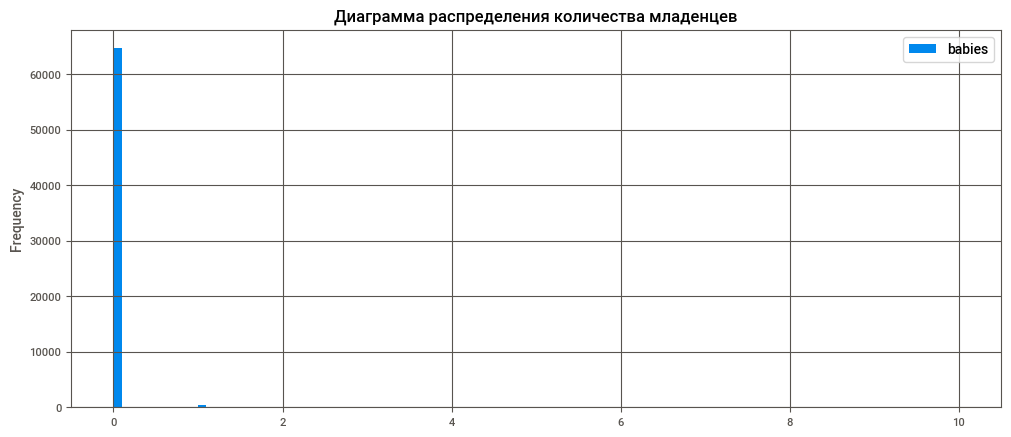

In [12]:
# построение диаграммы распределения
build_hist(df_train, 'babies', 'Диаграмма распределения количества младенцев')

Из диаграммы распределения видим, что бóльшая часть клиентов приезжает без младенцев и почти вся оставшаяся часть приезжает с одним ребёнком. Однако уникальных значений в этой колонке признака больше, поэтому рассмотрим поближе промежуток от 2 до 10.

Значения, которые принимает признак и частота появления этих значений:
2     3
9     1
10    1
Name: babies, dtype: int64
count     5.000000
mean      5.000000
std       4.123106
min       2.000000
25%       2.000000
50%       2.000000
75%       9.000000
max      10.000000
Name: babies, dtype: float64


<AxesSubplot:title={'center':'Диаграмма распределения количества младенцев'}, ylabel='Frequency'>

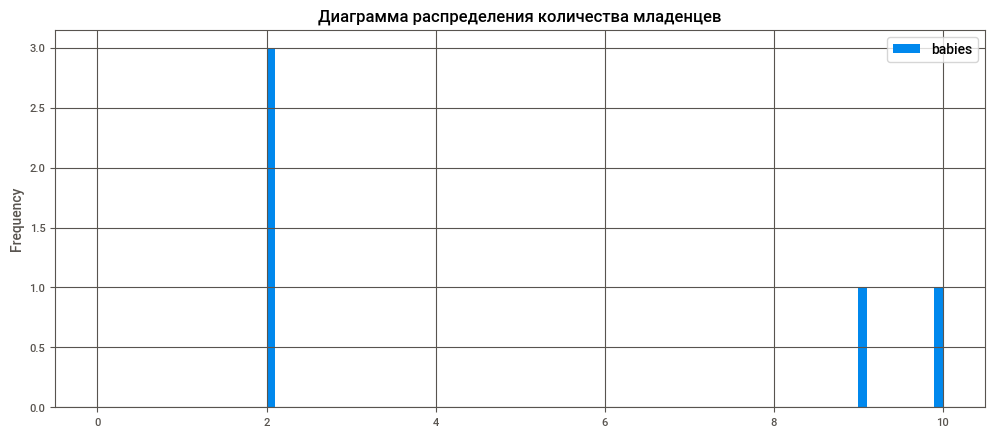

In [13]:
# построение диаграммы распределения
build_hist(df_train.query('2 <= babies <= 10'), 'babies', 'Диаграмма распределения количества младенцев')

С двумя младенцами прибыло только трое клиентов, с 9ю и 10ю младенцами — по одному. Цифры в 9 и 10 младенцев кажутся неправдоподобными, тем более, в данных такие клиенты встречаются только по одному разу. Отбросим клиентов с 9ю и 10ю младенцами.

In [14]:
# фильтрация по количеству младенцев
df_train = df_train.query('babies < 9')

In [15]:
# проверка фильтрации
df_train['babies'].unique()

array([0, 1, 2])

Теперь посмотрим на распределение количества младенцев у клиентов в таблице *df_test*.

Значения, которые принимает признак и частота появления этих значений:
0    32237
1      171
2        4
Name: babies, dtype: int64
count    32412.000000
mean         0.005523
std          0.075757
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: babies, dtype: float64


<AxesSubplot:title={'center':'Диаграмма распределения количества младенцев'}, ylabel='Frequency'>

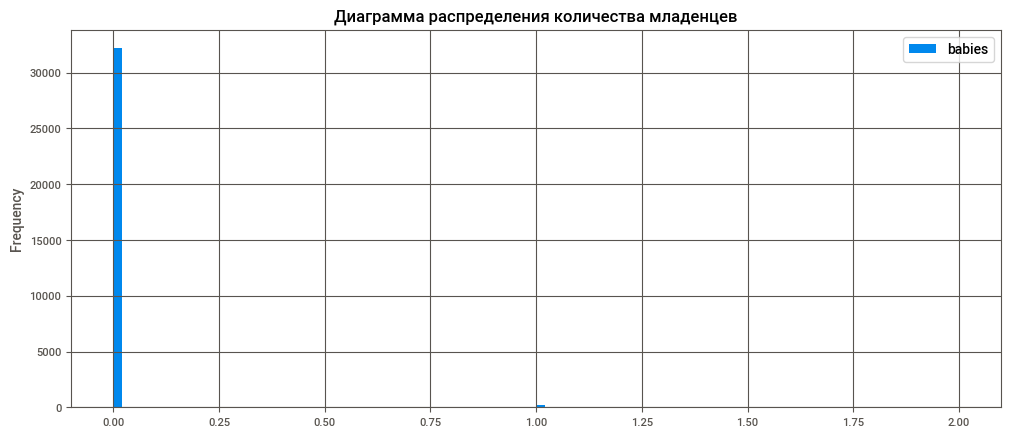

In [16]:
# построение диаграммы распределения
build_hist(df_test, 'babies', 'Диаграмма распределения количества младенцев')

Так же, как и в предыдущем распределении, клиенты предпочитают приезжать в отель без младенцев. Максимальное количество младенцев у клиента — 2. Аномалий и выбросов в распределении не обнаружено.

Далее рассмотрим распределения количества отмен бронирования.

Значения, которые принимает признак и частота появления этих значений:
0     59591
1      5367
2        54
3        51
11       35
24       28
25       19
26       18
19       17
5        13
13       12
14       11
6         7
4         5
21        1
Name: previous_cancellations, dtype: int64
count    65229.000000
mean         0.128915
std          0.965326
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         26.000000
Name: previous_cancellations, dtype: float64
Значения, которые принимает признак и частота появления этих значений:
0    32186
1      165
2       29
6       15
4       10
3        6
5        1
Name: previous_cancellations, dtype: int64
count    32412.000000
mean         0.011601
std          0.180473
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          6.000000
Name: previous_cancellations, dtype: float64


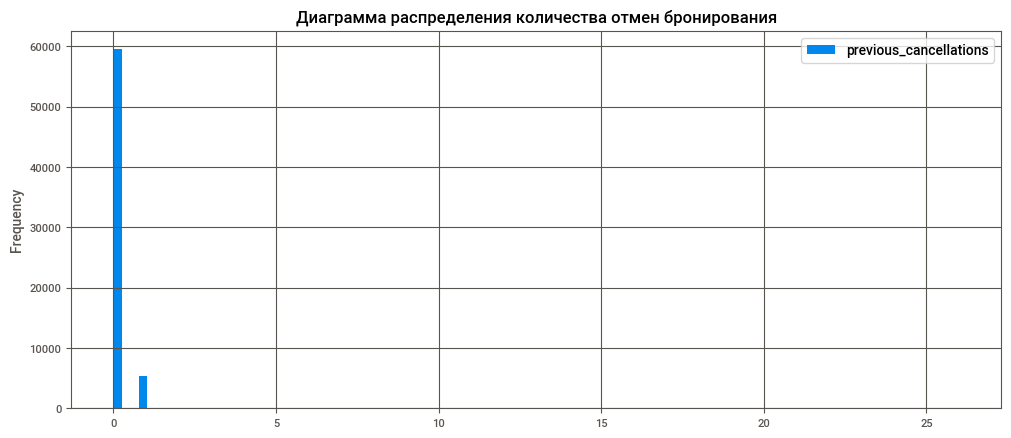

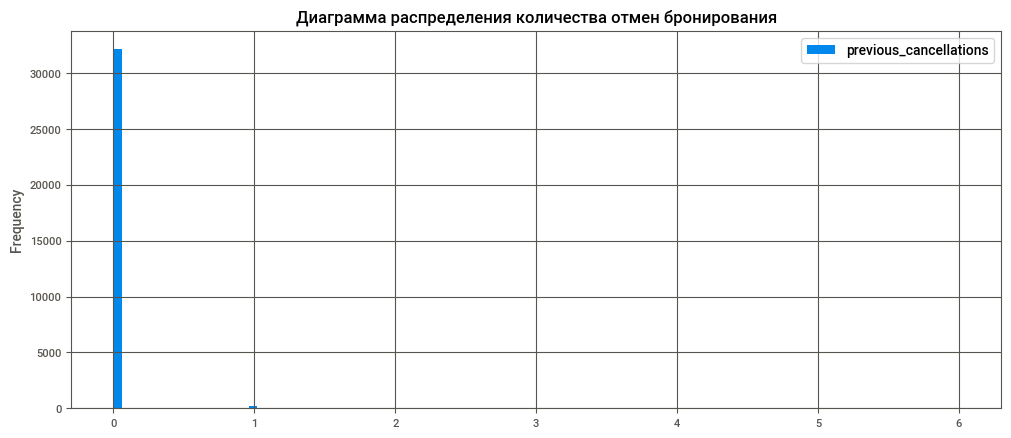

In [17]:
# построение диаграмм распределения
for df in dfs:
    build_hist(df, 'previous_cancellations', 'Диаграмма распределения количества отмен бронирования')

Судя по графикам, клиенты отеля в основном не отменяют бронирования. Однако в характеристиках первого графика мы видим, что максимальное количество отмен бронирования достигает 26 раз. Посмотрим поближе на промежуток от 1 до 26 этого графика.

Значения, которые принимает признак и частота появления этих значений:
1     5367
2       54
3       51
11      35
24      28
25      19
26      18
19      17
5       13
13      12
14      11
6        7
4        5
21       1
Name: previous_cancellations, dtype: int64
count    5638.000000
mean        1.491486
std         2.958080
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        26.000000
Name: previous_cancellations, dtype: float64


<AxesSubplot:title={'center':'Диаграмма распределения количества отмен бронирования'}, ylabel='Frequency'>

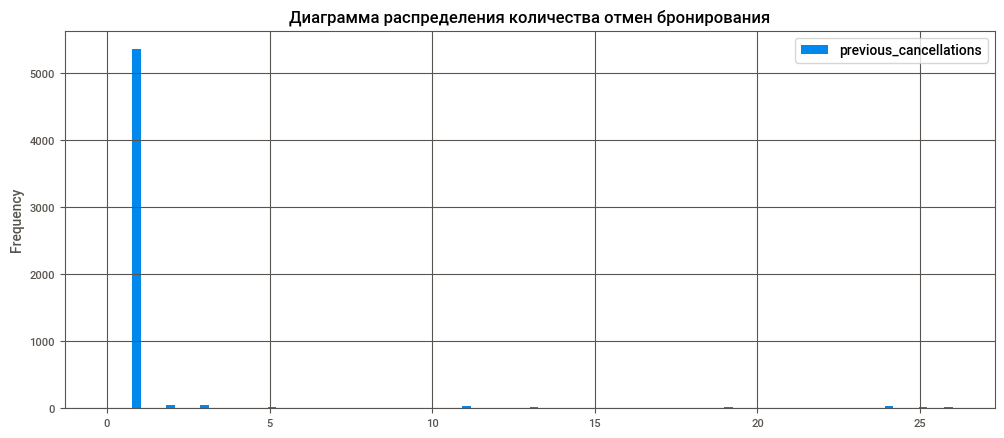

In [18]:
# построение диаграмм распределения
build_hist(df_train.query('1 <= previous_cancellations <= 26'), 'previous_cancellations', 'Диаграмма распределения количества отмен бронирования')

Основная часть данных сосредоточена в промежутке от 1 до 5. Значения после 10 встречаются редко. Посмотрим на их долю относительно всего датафрейма.

In [19]:
# просмотр доли признака
round((df_train.query('previous_cancellations > 10').count() / df_train['previous_cancellations'].count())[0], 4)

0.0022

Значения, превышающие 10, составляют менее 1% данных. Избавимся от столь редких значений.

In [20]:
# фильтрация таблицы
df_train = df_train.query('previous_cancellations < 10')

In [21]:
# проверка фильтрации
df_train['previous_cancellations'].unique()

array([0, 1, 2, 3, 4, 5, 6])

Приступаем к распределнию количества изменений параметров заказа.

Значения, которые принимает признак и частота появления этих значений:
0     56195
1      6615
2      1754
3       413
4       149
5        42
6        19
7        18
8         7
9         5
13        4
10        2
14        2
15        2
16        1
17        1
Name: booking_changes, dtype: int64
count    65229.000000
mean         0.194269
std          0.593838
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         17.000000
Name: booking_changes, dtype: float64
Значения, которые принимает признак и частота появления этих значений:
0     27745
1      3065
2      1160
3       268
4       117
5        29
6        16
7         5
16        1
18        1
8         1
10        1
11        1
14        1
15        1
Name: booking_changes, dtype: int64
count    32412.000000
mean         0.216741
std          0.640551
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         18.000000
Name: booking_changes, d

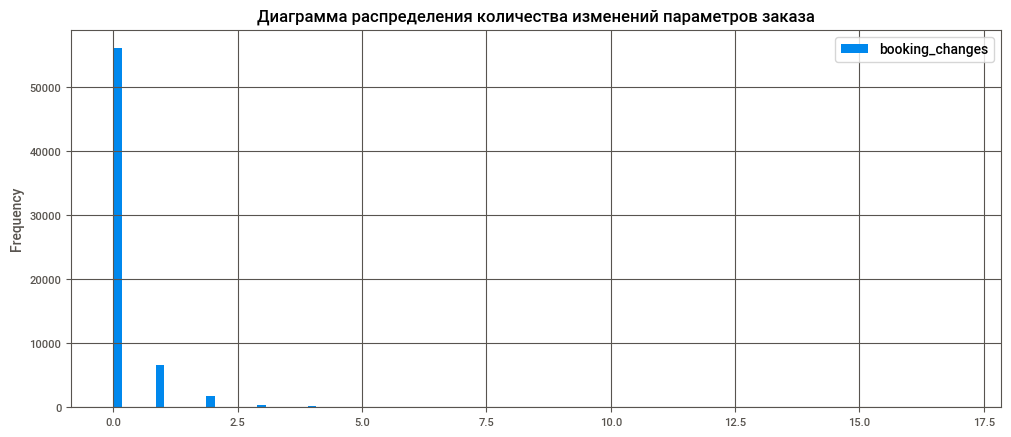

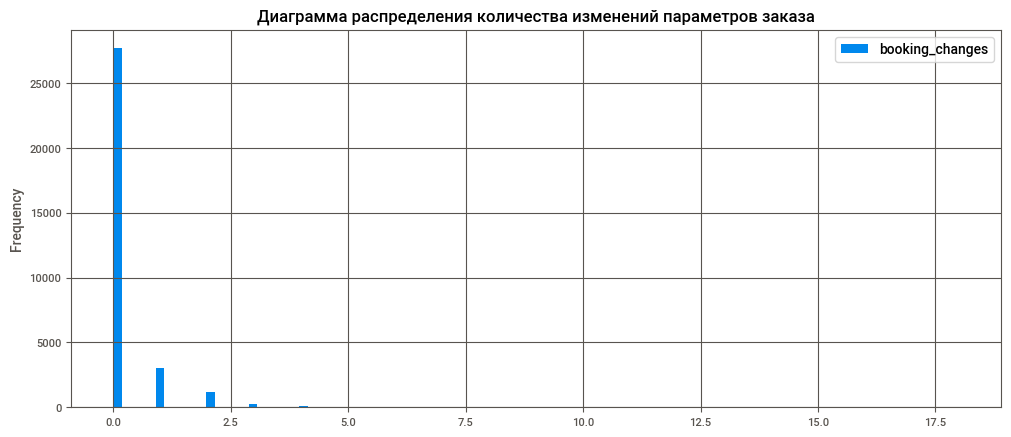

In [22]:
# построение диаграмм распределения
for df in dfs:
    build_hist(df, 'booking_changes', 'Диаграмма распределения количества изменений параметров заказа')

Значения сконцентрированы в промежутке от 0 до 5. Рассмотрим промежуток от 5 до 18.

Значения, которые принимает признак и частота появления этих значений:
5     42
6     19
7     18
8      7
9      5
13     4
10     2
14     2
15     2
16     1
17     1
Name: booking_changes, dtype: int64
count    103.000000
mean       6.932039
std        2.769803
min        5.000000
25%        5.000000
50%        6.000000
75%        7.000000
max       17.000000
Name: booking_changes, dtype: float64
Значения, которые принимает признак и частота появления этих значений:
5     29
6     16
7      5
8      1
10     1
11     1
14     1
15     1
16     1
18     1
Name: booking_changes, dtype: int64
count    57.000000
mean      6.456140
std       2.854008
min       5.000000
25%       5.000000
50%       5.000000
75%       6.000000
max      18.000000
Name: booking_changes, dtype: float64


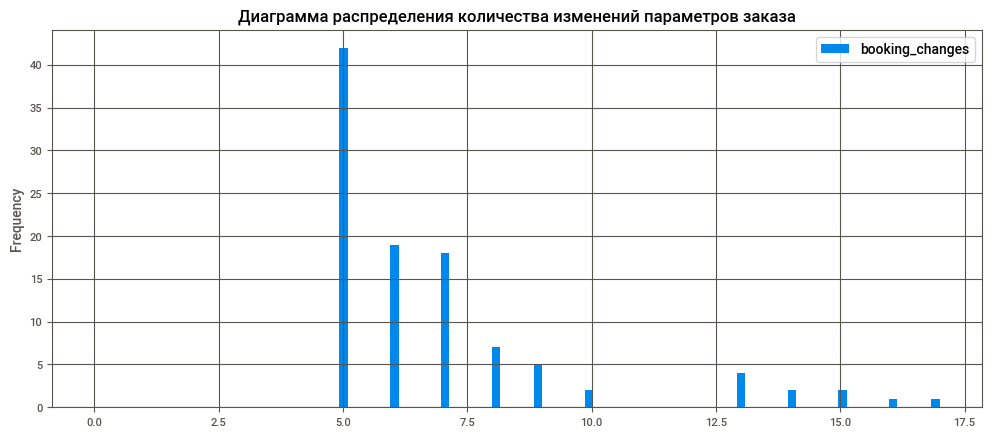

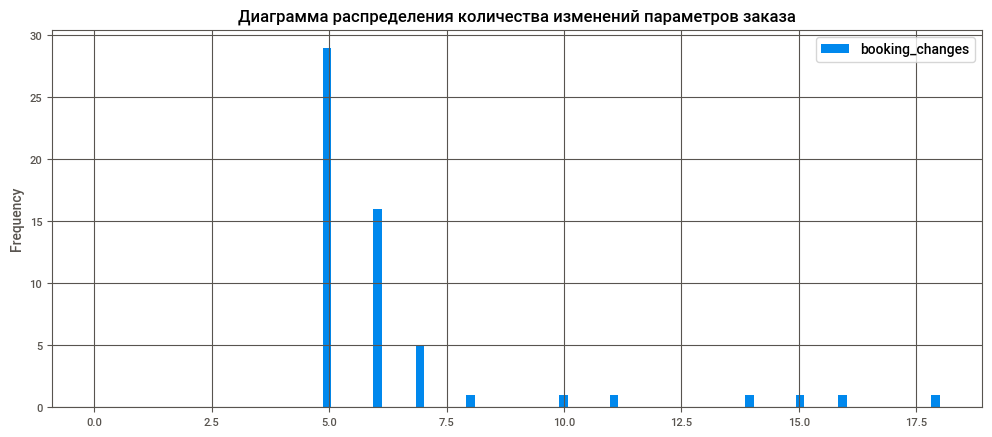

In [23]:
# построение диаграмм распределения
for df in dfs:
    build_hist(df.query('5 <= booking_changes <= 18'), 'booking_changes', 'Диаграмма распределения количества изменений параметров заказа')

Значения после 8 встречаются редко. Посмотрим на их долю относительно всего датафрейма.

In [24]:
# просмотр доли признака
round((df_train.query('booking_changes > 8').count() / df_train['booking_changes'].count())[0], 4)

0.0003

Доля переменных, принимающих значения после 8, совсем небольшая, однако значения не выглядят аномальными, т.к. вполне возможно, что отедльыне клиенты меняли параметры заказа по много раз.

Далее переходим к распределению количества подтверждённых заказов.

Значения, которые принимает признак и частота появления этих значений:
0     63686
1       645
2       252
3       136
4       114
5        89
6        56
7        34
8        25
9        23
10       21
11       16
12       14
25       10
13        9
21        8
14        8
22        7
15        7
16        6
20        5
19        5
18        5
17        5
24        3
27        3
29        2
28        2
44        2
23        2
48        2
41        1
54        1
55        1
56        1
53        1
33        1
57        1
26        1
58        1
30        1
34        1
51        1
35        1
52        1
40        1
50        1
49        1
47        1
32        1
36        1
45        1
37        1
38        1
43        1
39        1
42        1
31        1
Name: previous_bookings_not_canceled, dtype: int64
count    65229.000000
mean         0.107713
std          1.326638
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         58.000000
Name: 

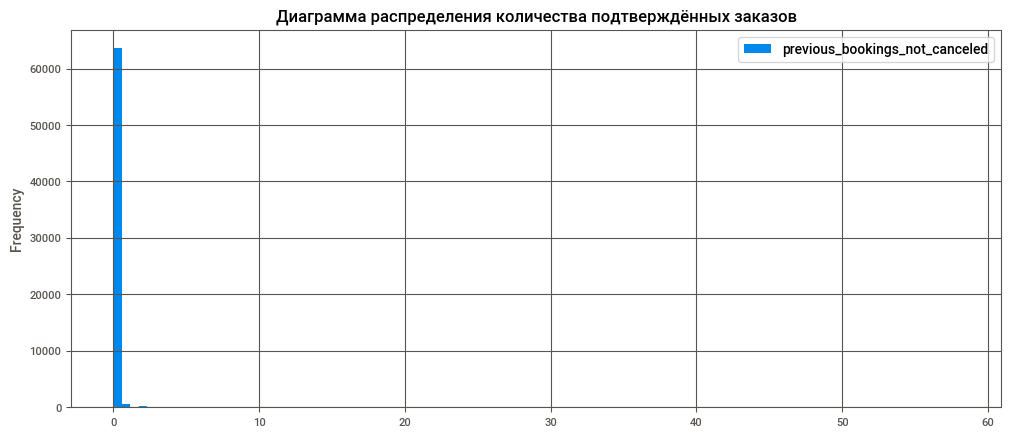

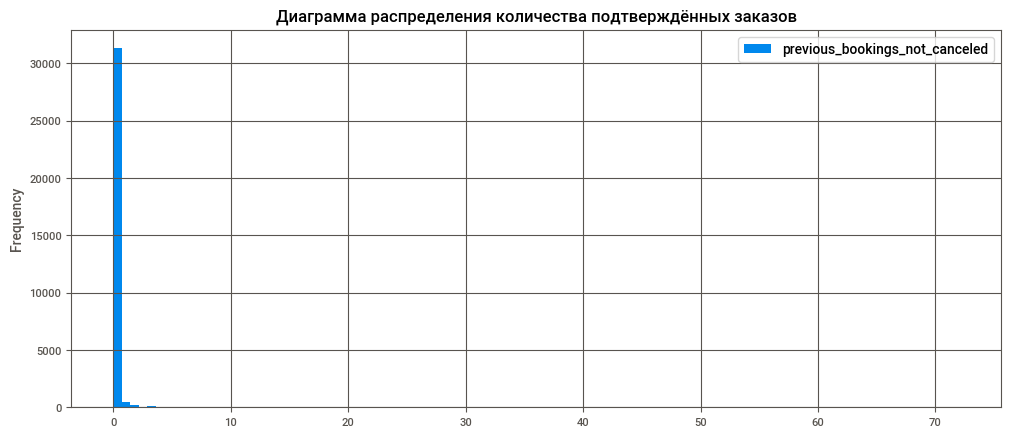

In [25]:
# построение диаграмм распределения
for df in dfs:
    build_hist(df, 'previous_bookings_not_canceled', 'Диаграмма распределения количества подтверждённых заказов')

Чаще всего клиенты не подтверждали заказ. Бóльшая часть данных сосредоточена на промежутке от 0 до 5. По сводке характеристик распределения видим, что есть значения и за пределами указанного диапазона. Посмотрим на них поближе.

Значения, которые принимает признак и частота появления этих значений:
1     645
2     252
3     136
4     114
5      89
6      56
7      34
8      25
9      23
10     21
11     16
12     14
25     10
13      9
21      8
14      8
22      7
15      7
16      6
17      5
18      5
19      5
20      5
24      3
27      3
48      2
44      2
29      2
28      2
23      2
26      1
57      1
56      1
55      1
54      1
53      1
52      1
51      1
50      1
49      1
47      1
45      1
43      1
30      1
42      1
41      1
40      1
39      1
38      1
37      1
36      1
35      1
34      1
33      1
32      1
31      1
58      1
Name: previous_bookings_not_canceled, dtype: int64
count    1543.000000
mean        4.553467
std         7.361490
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        58.000000
Name: previous_bookings_not_canceled, dtype: float64
Значения, которые принимает признак и частота появления этих значений:
1     424
2     

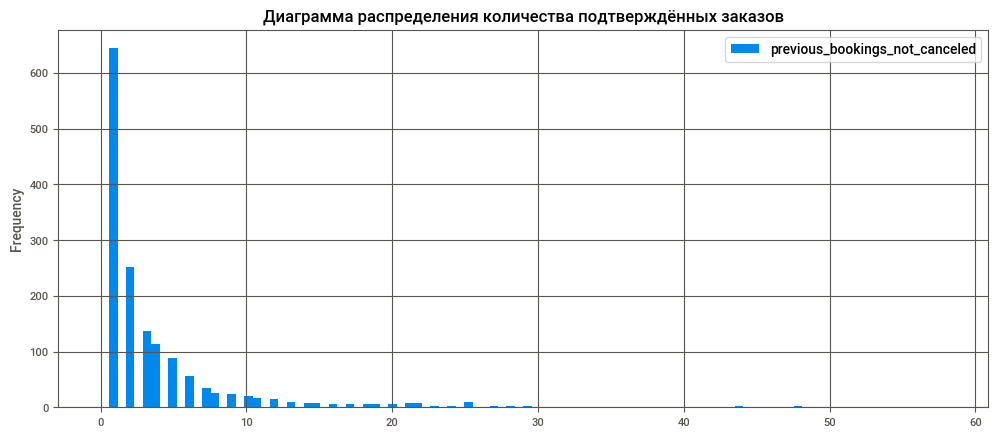

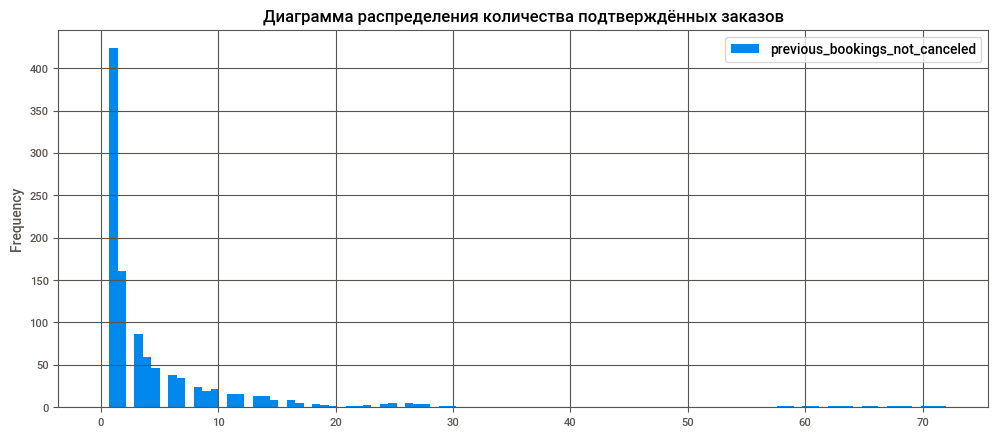

In [26]:
# построение диаграмм распределения
for df in dfs:
    build_hist(df.query('1 <= previous_bookings_not_canceled <= 72'), 'previous_bookings_not_canceled', 'Диаграмма распределения количества подтверждённых заказов')

Из диаграмм видим, что значения после 30 почти не встречаются. Однако могут существовать постояльцы, которые предпочитают останавливаться только в этом отеле.

Теперь рассмотрим распределение количества дней до подтверждения заказа.

Значения, которые принимает признак и частота появления этих значений:
0      62005
39       185
58       164
44       137
31       126
       ...  
89         1
76         1
13         1
142        1
14         1
Name: days_in_waiting_list, Length: 97, dtype: int64
count    65229.000000
mean         3.334422
std         18.239606
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        259.000000
Name: days_in_waiting_list, dtype: float64
Значения, которые принимает признак и частота появления этих значений:
0      32235
59         6
71         6
60         6
25         6
       ...  
57         1
73         1
105        1
121        1
223        1
Name: days_in_waiting_list, Length: 75, dtype: int64
count    32412.000000
mean         0.262341
std          4.733027
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        223.000000
Name: days_in_waiting_list, dtype: float64


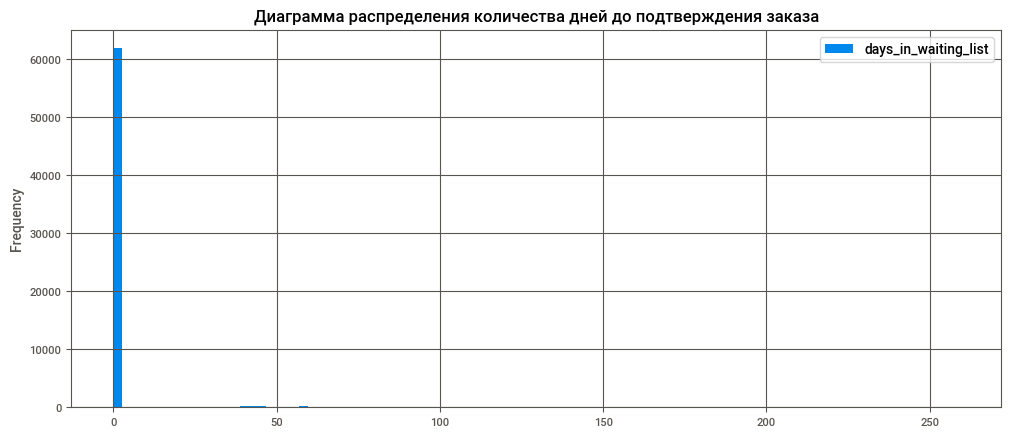

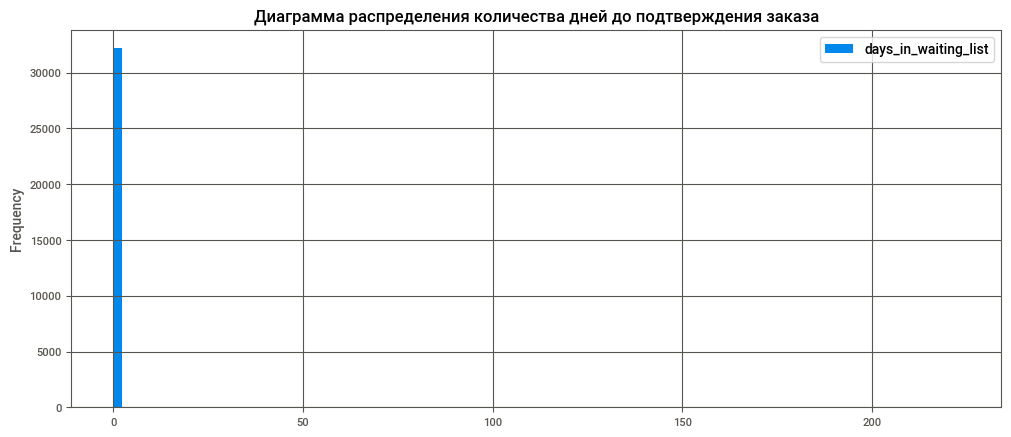

In [27]:
# построение диаграмм распределения
for df in dfs:
    build_hist(df, 'days_in_waiting_list', 'Диаграмма распределения количества дней до подтверждения заказа')

Как правило, клиенты подтверждают заказ в день бронирования. Но имеются и исключения из правил. Попробуем их отобразить более детально.

Значения, которые принимает признак и частота появления этих значений:
39     185
58     164
44     137
31     126
35      95
      ... 
167      1
14       1
193      1
81       1
76       1
Name: days_in_waiting_list, Length: 96, dtype: int64
count    3224.000000
mean       67.463089
std        49.043636
min         1.000000
25%        38.000000
50%        56.000000
75%        87.000000
max       259.000000
Name: days_in_waiting_list, dtype: float64
Значения, которые принимает признак и частота появления этих значений:
59     6
71     6
60     6
25     6
5      5
      ..
54     1
57     1
65     1
73     1
223    1
Name: days_in_waiting_list, Length: 74, dtype: int64
count    177.000000
mean      48.039548
std       42.627264
min        1.000000
25%       16.000000
50%       34.000000
75%       63.000000
max      223.000000
Name: days_in_waiting_list, dtype: float64


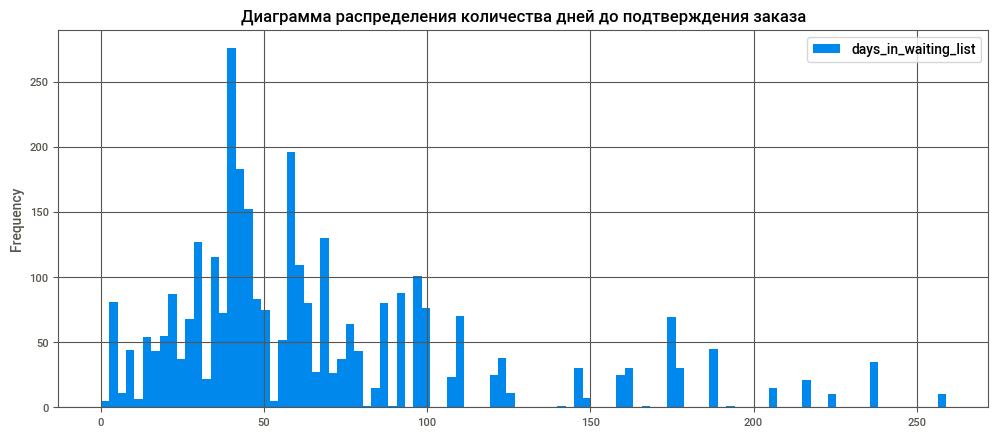

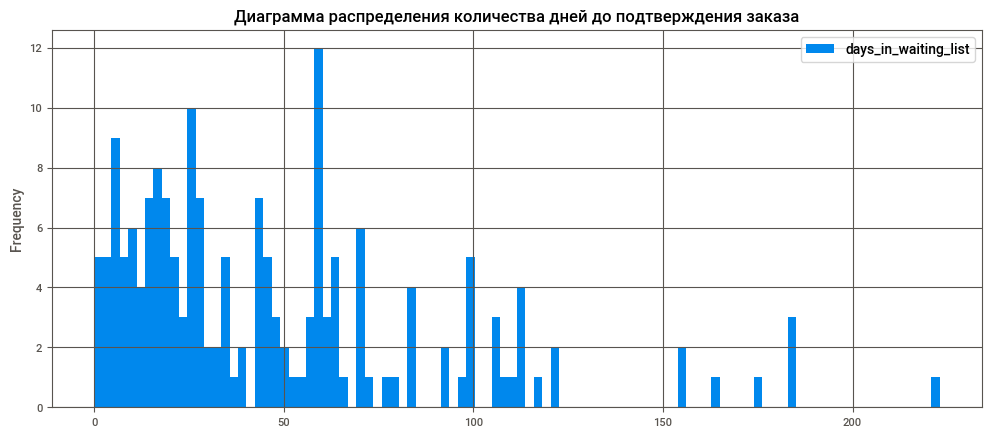

In [28]:
# построение диаграмм распределения
for df in dfs:
    build_hist(df.query('1 <= days_in_waiting_list <= 259'), 'days_in_waiting_list', 'Диаграмма распределения количества дней до подтверждения заказа')

На обоих графиках значения после 200 почти не встречаются. Однако клиенты могут забронировать несколько отелей, а ближе к дате поездки точно определиться с местом проживания, поэтому значения после 200 не кажутся аномальными.

Наконец переходим к распределению количества запрошенных парковочных мест.

Значения, которые принимает признак и частота появления этих значений:
0    61547
1     3670
2       11
3        1
Name: required_car_parking_spaces, dtype: int64
count    65229.000000
mean         0.056647
std          0.232094
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: required_car_parking_spaces, dtype: float64
Значения, которые принимает признак и частота появления этих значений:
0    30935
1     1468
2        6
8        2
3        1
Name: required_car_parking_spaces, dtype: int64
count    32412.000000
mean         0.046248
std          0.219367
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: required_car_parking_spaces, dtype: float64


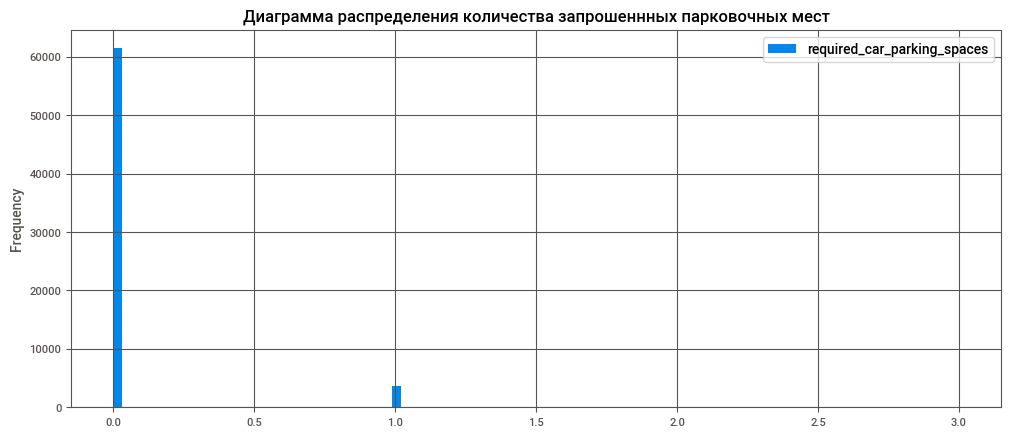

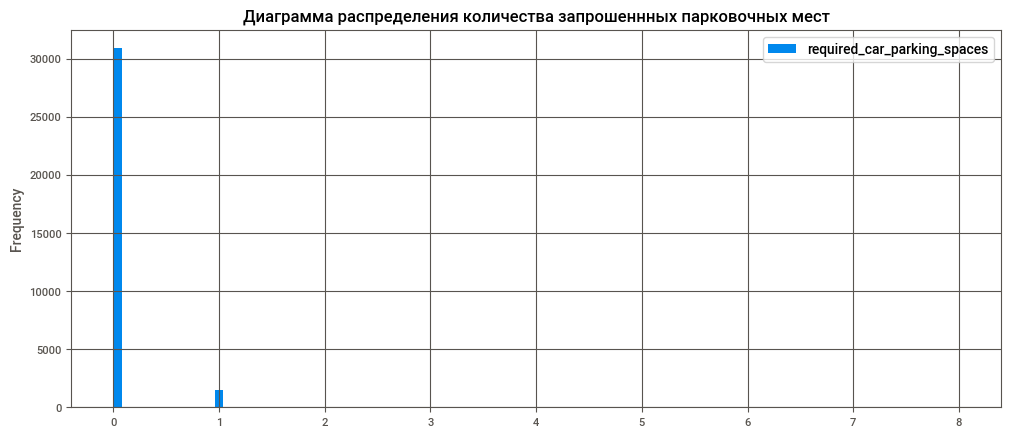

In [29]:
# построение диаграмм распределения
for df in dfs:
    build_hist(df, 'required_car_parking_spaces', 'Диаграмма распределения количества запрошеннных парковочных мест')

Основная масса клиентов не запрашивает парковочное место. Другие запрашивают одно парковочное место. На 2 и более парковочных мест претендует малая часть клиентов. Посмотрим на эту часть поближе.

Значения, которые принимает признак и частота появления этих значений:
3    1
Name: required_car_parking_spaces, dtype: int64
count    1.0
mean     3.0
std      NaN
min      3.0
25%      3.0
50%      3.0
75%      3.0
max      3.0
Name: required_car_parking_spaces, dtype: float64
Значения, которые принимает признак и частота появления этих значений:
8    2
3    1
Name: required_car_parking_spaces, dtype: int64
count    3.000000
mean     6.333333
std      2.886751
min      3.000000
25%      5.500000
50%      8.000000
75%      8.000000
max      8.000000
Name: required_car_parking_spaces, dtype: float64


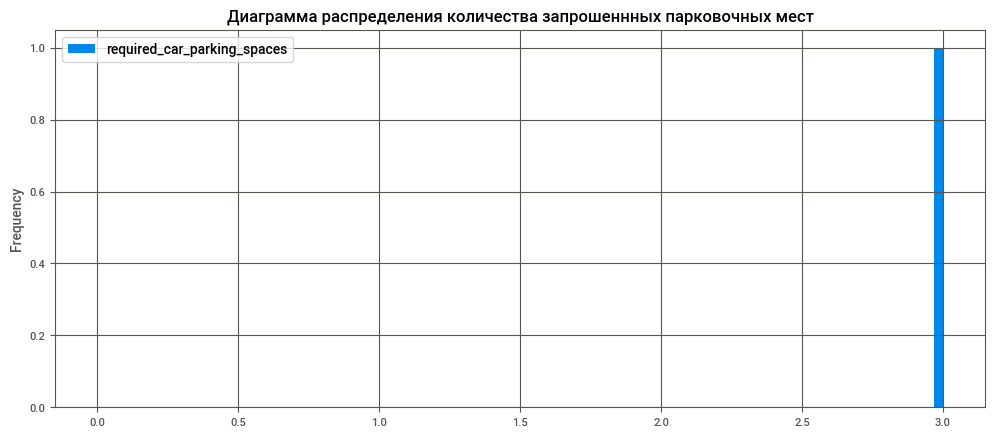

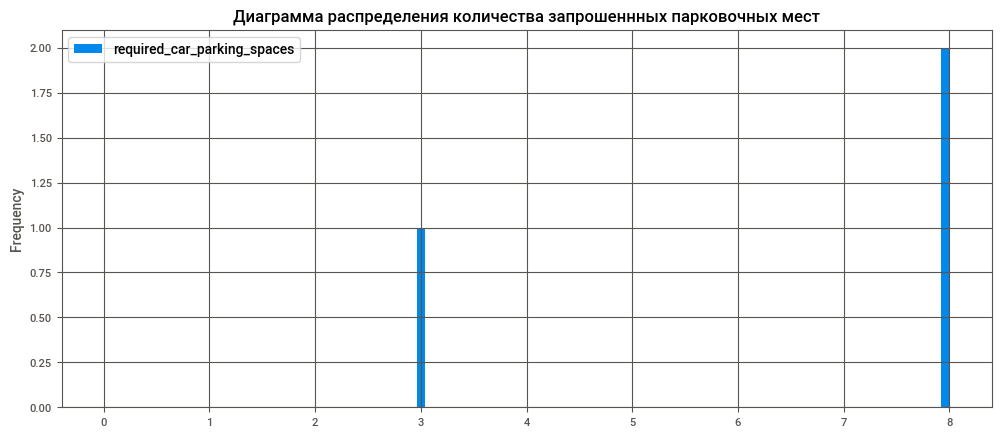

In [30]:
# построение диаграмм распределения
for df in dfs:
    build_hist(df.query('3 <= required_car_parking_spaces <= 8'), 'required_car_parking_spaces', 'Диаграмма распределения количества запрошеннных парковочных мест')

По одному человеку в обеих таблицы запросили 3 парковочных места. И лишь один клиент в таблице *df_test* запросил 8 парковочных мест. Данное значени отнесём к выбросам и избавимся от него.

In [31]:
# фильтрация таблицы и проверка фильтрации с помощью вывода максимальных значений
df_test = df_test.query('required_car_parking_spaces < 8')
df_test['required_car_parking_spaces'].max()

3

Теперь займёмся приведением категориальных значений переменных к единому формату. Это приведение коснётся столбцов `meal` и `reserved_room_type`.

In [32]:
# вывод уникальных значений первой таблицы
df_train['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

In [33]:
# приведение к единому формату столбца 'meal' в первой таблице
df_train['meal'] = df_train['meal'].str.rstrip()
df_train['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

In [34]:
# приведение к единому формату столбца 'meal' во второй таблице
df_test['meal'] = df_test['meal'].str.rstrip()
df_test['meal'].unique()

/tmp/ipykernel_178/685787669.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['meal'] = df_test['meal'].str.rstrip()


array(['BB', 'HB', 'SC', 'FB'], dtype=object)

In [35]:
# приведение к единому формату столбца 'reserved_room_type' в обеих таблицах
df_train['reserved_room_type'] = df_train['reserved_room_type'].str.rstrip()
df_test['reserved_room_type'] = df_test['reserved_room_type'].str.rstrip()

/tmp/ipykernel_178/717383429.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['reserved_room_type'] = df_test['reserved_room_type'].str.rstrip()


В обоих датафреймах содержится столбец `id`, который не пригодится при обучении модели. Исключим этот столбец из таблиц.

In [40]:
# удаление столбца
df_train = df_train.drop('id', axis=1)
df_test = df_test.drop('id', axis=1)

In [41]:
# проверка наличия столбца
df_train.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_nights'],
      dtype='object')

**Вывод:**

Данные исследованы и предобработаны. Приступаем к формулированию задачи машинного обучения.

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:
категория A: за ночь — 1 000, разовое обслуживание — 400;
категория B: за ночь — 800, разовое обслуживание — 350;
категория C: за ночь — 600, разовое обслуживание — 350;
категория D: за ночь — 550, разовое обслуживание — 150;
категория E: за ночь — 500, разовое обслуживание — 150;
категория F: за ночь — 450, разовое обслуживание — 150;
категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

Необходимо разработать **систему прогнозирования отмены бронирования**, чтобы при положительном прогнозе *(клиент отменит заказ)*, компания брала депозит с клиента, обеспечивая положительную прибыль отелю. На разработку заложен бюджет — 400 000. При этом мы должны учесть, что внедрение модели должно окупиться за год. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

Для начала рассчитаем прибыль компании без внедрения депозитов и системы прогнозирования. Составим отедльную таблицу для удобного расчёта.

In [42]:
# функция расчёта цены номера
def price_per_night(row):
    room_types = {
        'A' : 1000,
        'B' : 800,
        'C' : 600,
        'D' : 550,
        'E' : 500,
        'F' : 450,
        'G' : 350
    }
    room_type = row['room_category']
    return room_types[room_type]

In [43]:
# функция расчёта одного обслуживания номера
def price_per_one_service(row):
    room_types = {
        'A' : 400,
        'B' : 350,
        'C' : 350,
        'D' : 150,
        'E' : 150,
        'F' : 150,
        'G' : 150
    }
    room_type = row['room_category']
    return room_types[room_type]

In [44]:
# функция присвоения сезонного коэффициента
def coeff(row):
    coeffs = {
        'January' : 1,
        'February' : 1,
        'March' : 1.2,
        'April' : 1.2,
        'May' : 1.2,
        'June' : 1.4,
        'July' : 1.4,
        'August' : 1.4,
        'September' : 1.2,
        'October' : 1.2,
        'November' : 1.2,
        'December' : 1
    }
    coeff_type = row['arrival_date_month']
    return coeffs[coeff_type]

In [45]:
# функция составления таблицы для расчётов
def table_for_calc(new_df, base_df):
    new_df['room_category'] = base_df['reserved_room_type']
    new_df['price_per_night'] = new_df.apply(price_per_night, axis=1)
    new_df['nights'] = base_df['total_nights']
    new_df['price_per_one_service'] = new_df.apply(price_per_one_service, axis=1)
    new_df['service_count'] = np.floor(new_df['nights'] / 2).astype('int64')
    new_df['price_coeff'] = base_df.apply(coeff, axis=1)
    new_df['is_canceled'] = base_df['is_canceled']
    new_df['year'] = base_df['arrival_date_year']

Функция для составления расчётной таблицы подготовлены. Можно формировать таблицу.

In [46]:
# формирования таблицы для расчётов
df_calculated = pd.DataFrame()
table_for_calc(df_calculated, df_train)
# вывод первых строк таблицы
df_calculated.head()

,room_category,price_per_night,nights,price_per_one_service,service_count,price_coeff,is_canceled,year
0,A,1000,1,400,0,1.4,0,2015
1,A,1000,2,400,1,1.4,0,2015
2,C,600,2,350,1,1.4,0,2015
3,C,600,2,350,1,1.4,0,2015
4,A,1000,3,400,1,1.4,1,2015


Подготовим функцию расчёта прибыли без депозитов.

In [47]:
# функция расчёта прибыли без депозита
def profit_without_deposit(row):
    if row['is_canceled'] == 0:
        profit = (row['price_per_night'] * row['nights'] - row['price_per_one_service'] * row['service_count']) * row['price_coeff']
    else:
        profit = 0 - row['price_per_night'] * row['price_coeff']
    return profit

Применим функцию к нашей таблице.

In [48]:
# применение функции 
df_calculated['profit'] = df_calculated.apply(profit_without_deposit, axis=1)
# вывод первых строк таблицы
df_calculated.head()

,room_category,price_per_night,nights,price_per_one_service,service_count,price_coeff,is_canceled,year,profit
0,A,1000,1,400,0,1.4,0,2015,1400.0
1,A,1000,2,400,1,1.4,0,2015,2240.0
2,C,600,2,350,1,1.4,0,2015,1190.0
3,C,600,2,350,1,1.4,0,2015,1190.0
4,A,1000,3,400,1,1.4,1,2015,-1400.0


Посмотрим, за какие года мы имеем информацию, и рассчитаем среднюю прибыль.

In [49]:
# вывод уникальных значений годов
df_calculated['year'].unique()

array([2015, 2016])

Теперь проверим: имеем мы информацию за полные два года или за определённое количество месяцев.

In [60]:
# просмотр количества месяцев
print(len(df_train[df_train['arrival_date_year'] == 2015]['arrival_date_month'].unique()))
print(len(df_train[df_train['arrival_date_year'] == 2016]['arrival_date_month'].unique()))

6
12


Чтобы посчитать среднюю прибыль за год по имеющимся данным, необходимо рассчитать среднюю прибыль за месяц и умножить на количество месяцев в году.

In [63]:
# расчёт средней прибыли
mean_year_profit = (df_calculated['profit'].sum() / 18) * 12
print(f'Годовая средняя прибыль отеля без внедрения депозитов составляет', round(mean_year_profit, 2), f'руб.')

Годовая средняя прибыль отеля без внедрения депозитов составляет 56760673.33 руб.


**Вывод:**

Сформулирована задача машинного обучения. Рассчитана среднегодовая прибыль отеля (по тренировочным данным) без внедрения депозита и системы прогнозирования .

### Шаг 4. Разработка модели ML

Чтобы приступить к обучению модели, необходимо **подготовить входные данные** *обучающей и тестовой* выборок:

* все имеющиеся признаки привести к количественному формату
* разделить исходные данные на признаки (все, кроме колонки `is_cancelled` и `id`) и целевой признак (колонка `is_cancelled`)

Воспользуемся структурой *OneHotEncoder()* для кодирования данных (приведения к количественному формату). Отберём только категориальные столбцы.

In [65]:
# кодирование данных обучающей выборки
columns_to_encode = ['arrival_date_month', 'country', 'customer_type', 'distribution_channel', 'meal', 'reserved_room_type']
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(df_train[columns_to_encode])
data_ohe_train = pd.DataFrame(encoder.transform(df_train[columns_to_encode]), columns=encoder.get_feature_names(columns_to_encode))
# просмотр первых строк таблицы
data_ohe_train.head()

,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,...,meal_FB,meal_HB,meal_SC,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
# кодирование данных тестовой выборки
data_ohe_test = pd.DataFrame(encoder.transform(df_test[columns_to_encode]), columns=encoder.get_feature_names(columns_to_encode))
# просмотр первых строк тыблицы
data_ohe_test.head()

,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,...,meal_FB,meal_HB,meal_SC,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Создадим отдельные таблицы данных с закодированным столбцами для дальнейшего обучения моделей на этих данных.

In [99]:
# создание таблиц с данными изначально количественного формата
numeric_train = df_train.drop(columns_to_encode, axis=1).reset_index().drop('index', axis=1)
numeric_test = df_test.drop(columns_to_encode, axis=1).reset_index().drop('index', axis=1)
# создание таблиц данных для обучения моделей
data_train = pd.concat([numeric_train, data_ohe_train], axis=1)
data_test = pd.concat([numeric_test, data_ohe_test], axis=1)
# просмотр первых строк таблицы
data_test.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,meal_FB,meal_HB,meal_SC,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G
0,1,74,2017,1,1,1,0,2,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,62,2017,1,1,2,2,2,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,62,2017,1,1,2,2,2,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,71,2017,1,1,2,2,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,172,2017,1,1,2,5,2,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Теперь разделим данные на признаки и целевой признак.

In [100]:
# деление выборок на признаки и целевой признак
features_train = data_train.drop(['is_canceled'], axis=1)
target_train = data_train['is_canceled']

features_test = data_test.drop(['is_canceled'], axis=1)
target_test = data_test['is_canceled']

Разбросы значений в колонках датафрейма отличаются. Те признаки, у которых разброс данных значительный, будут автоматически признаны алгоритмами моделей машинного обучения более важными. В действительности это не так. Чтобы признаки считались равнозначными, воспользуемся **мастабированием признаков**. Применим метод **стандартизации данных** с помощью структуры данных *StandardScaler*.

In [101]:
# отключение предупреждения
pd.options.mode.chained_assignment = None

# стандартизация данных
numeric = ['adults', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month',
               'babies', 'booking_changes', 'children', 'days_in_waiting_list', 'lead_time',
               'previous_bookings_not_canceled', 'previous_cancellations', 'stays_in_weekend_nights', 
               'stays_in_week_nights', 'total_nights', 'total_of_special_requests']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Прежде чем рассматривать различные модели машинного обучения, посмотрим на классовое распределение целевого признака. В случае дисбаланса классов применим специальные методы борьбы с ним.

Text(0.5, 1.0, 'Диаграмма распределения количества клиентов, отменивших бронирование')

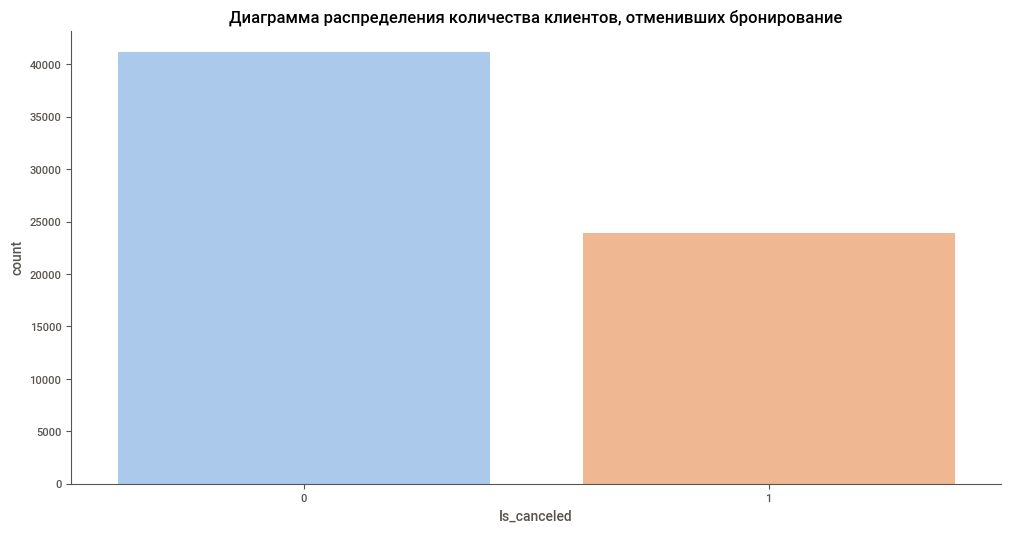

In [102]:
# графическое представление классового распределение целевого признака
data = pd.DataFrame({'Is_canceled':target_train})
f, ax = plt.subplots(figsize=(12, 6))
sns.despine(f)
sns.countplot(data=data, x='Is_canceled', palette='pastel')
ax.set_title('Диаграмма распределения количества клиентов, отменивших бронирование')

Из графического представления распределения классов видим, что количество клиентов, отменивших бронирование, намного меньше количества тех клиентов, которые бронирование подтвердили.

Рассмотрим три модели машинного обучения:
* `решающее дерево`
* `случайный лес`
* `логистическая регрессия`

В качестве целевой метрики будем использовать метрику качества *F1-score*, т.к. она объединяет в себе такие метрики качества, как *recall* и *precision*, которые должны принимать максимальные значения для точной работы модели.

Оценим качество модели, используя метод **кросс-валидации** с выбранной целевой метрикой, а затем, отобрав лучшую модель, обучим её на тренировочной выборке и проверим на тестовой.

> В первом случае для борьбы с дисбалансом классов будем использовать параметр *class_weight='balanced'* в каждой из моделей.

In [103]:
# модель решающего дерева
best_model = None
best_result = 0
best_max_depth = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    scores = cross_val_score(model, features_train, target_train, cv=5, scoring='f1') 
    result = sum(scores) / len(scores)
    if result > best_result:
        best_model = model
        best_result = result
        best_max_depth = depth
        
print('F1-score лучшей модели:', round(best_result, 2),
      'Глубина дерева max_depth лучшей модели:', best_max_depth, sep='\n')

F1-score лучшей модели:
0.66
Глубина дерева max_depth лучшей модели:
2


In [104]:
# модель логистической регрессии
model = LogisticRegression(solver='liblinear', class_weight='balanced')
scores = cross_val_score(model, features_train, target_train, cv=5, scoring='f1')
result = round(sum(scores) / len(scores), 2)
print('F1-score модели:', round(result, 2), sep='\n')

F1-score модели:
0.51


In [105]:
# модель случайного леса
from sklearn.ensemble import RandomForestClassifier
best_model = None
best_result = 0
best_max_depth = 0
best_n_estimators = 0
for est in range(1, 70, 10):
    for depth in range(1, 11, 1):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        scores = cross_val_score(model, features_train, target_train, cv=5, scoring='f1')
        result = sum(scores) / len(scores)
        if result > best_result:
            best_model = model
            best_result = result
            best_max_depth = depth
            best_n_estimators = est
print('F1 лучшей модели:', round(best_result, 2),
      'Глубина дерева max_depth лучшей модели:', best_max_depth,
     'Количество деревьев n_estimators лучшей модели:', best_n_estimators, sep='\n')

F1 лучшей модели:
0.6
Глубина дерева max_depth лучшей модели:
1
Количество деревьев n_estimators лучшей модели:
11


Модель решающего дерева показала лучший результат.

Попробуем другой метод борьбы с дисбалансом классов — **downsampling** (уменьшение выборки).

In [106]:
# функция уменьшения выборки 
from sklearn.utils import shuffle
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled 

In [107]:
# модель случайного леса
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.2)

best_model = None
best_result = 0
best_max_depth = 0
best_n_estimators = 0
for est in range(1, 70, 10):
    for depth in range(1, 11, 1):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        scores = cross_val_score(model, features_downsampled, target_downsampled, cv=5, scoring='f1')
        result = sum(scores) / len(scores)
        if result > best_result:
            best_model = model
            best_result = result
            best_max_depth = depth
            best_n_estimators = est
print('F1 лучшей модели:', round(best_result, 2),
      'Глубина дерева max_depth лучшей модели:', best_max_depth,
     'Количество деревьев n_estimators лучшей модели:', best_n_estimators, sep='\n')

F1 лучшей модели:
0.9
Глубина дерева max_depth лучшей модели:
10
Количество деревьев n_estimators лучшей модели:
41


In [108]:
# модель решающего дерева
best_model = None
best_result = 0
best_max_depth = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    scores = cross_val_score(model, features_downsampled, target_downsampled, cv=5, scoring='f1') 
    result = sum(scores) / len(scores)
    if result > best_result:
        best_model = model
        best_result = result
        best_max_depth = depth
        
print('F1-score лучшей модели:', round(best_result, 2),
      'Глубина дерева max_depth лучшей модели:', best_max_depth, sep='\n')

F1-score лучшей модели:
0.91
Глубина дерева max_depth лучшей модели:
10


In [109]:
# модель логистической регрессии
model = LogisticRegression(solver='liblinear')
scores = cross_val_score(model, features_downsampled, target_downsampled, cv=5, scoring='f1')
result = round(sum(scores) / len(scores), 2)
print('F1-score модели:', round(result, 2), sep='\n')

F1-score модели:
0.89


С применением функции пропорционального уменьшения выборки соответственно классовому распределению качество моделей повысилось в среднем на 50%. Теперь попробуем воспользоваться другой техникой борьбы с дисбалансом классов — **upsampling** *(увеличение выборки)*.

In [110]:
# функция увеличения выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [111]:
# модель случайного леса
features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

best_model = None
best_result = 0
best_max_depth = 0
best_n_estimators = 0
for est in range(1, 70, 10):
    for depth in range(1, 11, 1):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        scores = cross_val_score(model, features_upsampled, target_upsampled, cv=5, scoring='f1')
        result = sum(scores) / len(scores)
        if result > best_result:
            best_model = model
            best_result = result
            best_max_depth = depth
            best_n_estimators = est
print('F1 лучшей модели:', round(best_result, 2),
      'Глубина дерева max_depth лучшей модели:', best_max_depth,
     'Количество деревьев n_estimators лучшей модели:', best_n_estimators, sep='\n')

F1 лучшей модели:
0.9
Глубина дерева max_depth лучшей модели:
10
Количество деревьев n_estimators лучшей модели:
41


In [112]:
# модель решающего дерева
best_model = None
best_result = 0
best_max_depth = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    scores = cross_val_score(model, features_upsampled, target_upsampled, cv=5, scoring='f1') 
    result = sum(scores) / len(scores)
    if result > best_result:
        best_model = model
        best_result = result
        best_max_depth = depth
        
print('F1-score лучшей модели:', round(best_result, 2),
      'Глубина дерева max_depth лучшей модели:', best_max_depth, sep='\n')

F1-score лучшей модели:
0.91
Глубина дерева max_depth лучшей модели:
10


In [113]:
# модель логистической регрессии
model = LogisticRegression(solver='liblinear')
scores = cross_val_score(model, features_upsampled, target_upsampled, cv=5, scoring='f1')
result = round(sum(scores) / len(scores), 2)
print('F1-score модели:', round(result, 2), sep='\n')

F1-score модели:
0.89


С применением функции пропорционального увеличения выборки соответственно классовому распределению модели не улучшили свои показатели по сравнению с предыдущим уменьшением выборки. **Модель решающего дерева** принимаем лучшей моделью для нашей задачи, т.к. она обладает высоким значением метрики качества и работает достаточно быстро. Теперь проверим выбранную модель на тестовой выборке. 

In [114]:
# модель решающего дерева downsampled
model = DecisionTreeClassifier(random_state=12345, max_depth=10)
model.fit(features_downsampled, target_downsampled)
predicted_test = model.predict(features_test)
result = f1_score(target_test, predicted_test)
print('F1-score модели:', round(result, 2), sep='\n')

F1-score модели:
0.65


In [115]:
# модель решающего дерева upsampled
model = DecisionTreeClassifier(random_state=12345, max_depth=10)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
result = f1_score(target_test, predicted_test)
print('F1-score модели:', round(result, 2), sep='\n')

F1-score модели:
0.67


Качество модели решающего дерева значительно снизилось на тестовой выборке. Модель, обученная на увеличенной выборке, показала чуть лучший результат.

Составим таблицу для расчёта прибыли компании после внедрения системы прогнозирования и депозитов.

In [116]:
# создание таблицы расчётов прибыли
df_profit_with_deposit = pd.DataFrame()
table_for_calc(df_profit_with_deposit, df_test)
df_profit_with_deposit['is_canceled_predict'] = pd.Series(predicted_test)
df_profit_with_deposit.head()

,room_category,price_per_night,nights,price_per_one_service,service_count,price_coeff,is_canceled,year,is_canceled_predict
0,A,1000,1,400,0,1.0,1,2017,1.0
1,A,1000,4,400,2,1.0,1,2017,0.0
2,A,1000,4,400,2,1.0,1,2017,0.0
3,A,1000,4,400,2,1.0,1,2017,1.0
4,A,1000,7,400,3,1.0,1,2017,1.0


Напишем функцию, которая произведёт подсчёт прибыли с учётом предсказаний модели.

In [117]:
# функция расчёта прибыли с применением системы прогнозирования и внедрения депозита
def profit_predict(row):
    if row['is_canceled'] == 0 and row['is_canceled_predict'] == 0 :
        profit = (row['price_per_night'] * row['nights'] - row['price_per_one_service'] * row['service_count']) * row['price_coeff']
    elif row['is_canceled'] == 1 and row['is_canceled_predict'] == 0:
        profit = 0 - row['price_per_night'] * row['price_coeff']
    elif row['is_canceled'] == 1 and row['is_canceled_predict'] == 1:
        profit = (row['price_per_night'] + row['price_per_one_service']) * row['price_coeff'] * 0.8 - row['price_per_one_service'] * row['price_coeff']
    else:
            profit = (row['price_per_night'] * row['nights'] - row['price_per_one_service'] * row['service_count']) * row['price_coeff']
    return profit

In [118]:
# применение функции расчёта прибыли
df_profit_with_deposit['profit'] = df_profit_with_deposit.apply(profit_predict, axis=1)

Посмотрим, за какие года собраны тестовые данные. 

In [119]:
# просмотр уникальных значений годов
df_profit_with_deposit['year'].unique()

array([2017])

Теперь уточним, за сколько месяцев 2017 года собрана информация.

In [122]:
# просмотр количества месяцев
print(len(df_test[df_test['arrival_date_year'] == 2017]['arrival_date_month'].unique()))

8


Чтобы посчитать годовую выручку, разделим прибыль за 2017 год на количество месяцев и умножим на 12.

In [123]:
# расчёт прибыли с учётом системы прогнозирования и депозитов
year_profit_with_deposit = (df_profit_with_deposit['profit'].sum() / 8) * 12 
print('Годовая прибыль с учётом системы прогнозирования и депозитов составляет', year_profit_with_deposit, 'руб.')

Годовая прибыль с учётом системы прогнозирования и депозитов составляет 89176092.0 руб.


Далее рассчитаем реальную прибыль, которую компания получила за этот же год.

In [124]:
# создание таблицы расчётов прибыли
df_profit_without_deposit = pd.DataFrame()
table_for_calc(df_profit_without_deposit, df_test)
df_profit_without_deposit.head()

,room_category,price_per_night,nights,price_per_one_service,service_count,price_coeff,is_canceled,year
0,A,1000,1,400,0,1.0,1,2017
1,A,1000,4,400,2,1.0,1,2017
2,A,1000,4,400,2,1.0,1,2017
3,A,1000,4,400,2,1.0,1,2017
4,A,1000,7,400,3,1.0,1,2017


In [125]:
# применение функции расчёта прибыли
df_profit_without_deposit['profit'] = df_profit_without_deposit.apply(profit_without_deposit, axis=1)

In [126]:
# подсчёт годовой прибыли
year_profit_without_deposit = (df_profit_without_deposit['profit'].sum() / 8) * 12
print('Реальная годовая прибыль без учёта системы прогнозирования и депозитов составляет', year_profit_without_deposit, 'руб.')

Реальная годовая прибыль без учёта системы прогнозирования и депозитов составляет 62259180.0 руб.


Рассчитаем, на сколько процентов прибыльнее было бы использовать модель машинного обучения вместе с внедрением депозитов.

In [127]:
# расчёт процентной выгоды внедрения системы прогнозирования
coeff = (year_profit_with_deposit / year_profit_without_deposit) * 100
print('Выигрыш в прибыли благодаря использованию системы прогнозирования и депозитов составляет', int(coeff), '% от реальной полученной прибыли.')

Выигрыш в прибыли благодаря использованию системы прогнозирования и депозитов составляет 143 % от реальной полученной прибыли.


2017 год в целом был прибыльным, если сравнить предполагаемую прибыль без внедрения системы депозитов за указанный год со средней прибылью за 2015 и 2016 года. Однако с использованием системы прогнозирования и внедрением депозитов, выручка увеличится на 43%.

**Вывод:**

Отобрана лучшая модель машинного обучения для прогнозирования отмены бронирования. Рассчитан процентный показатель увеличения выручки.

### Шаг 5. Опиcание портрета «ненадёжного» клиента

Воспользуемся *feature_importances_*, чтобы определить: какие факторы являются наиболее важными при моделировании, т.е. какие признаки оказывают значительное влияние на результат прогнозирования.

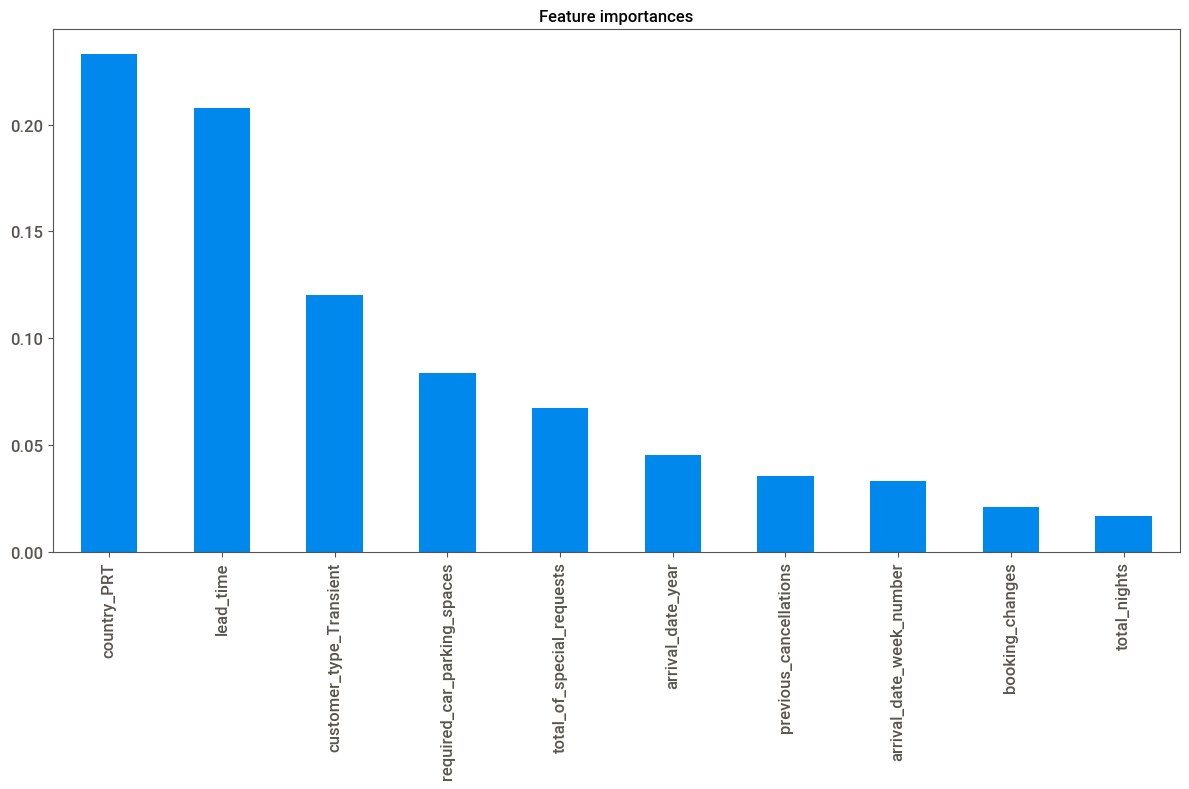

In [130]:
# вывод графика важности признаков
importances = model.feature_importances_
forest_importances = pd.Series(importances, index=features_train.columns)

fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).head(10).plot.bar(figsize=(12,8))
ax.set_title("Feature importances")
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(12)
fig.tight_layout()

Наиболее важными для прогнозирования являются следующие признаки: количество дней между датой бронирования и датой прибытия *lead_time*, необходимость места для автомобиля *required_car_parking_spaces*, количество специальных отметок *total_of_special_requests*. Посмотрим на графике, как указанные признаки распределены среди клиентов, отменивших и подтвердивших бронирование.

In [131]:
# функция построения распределения признака для клиентов, отменивших бронирование
def feature_distribution_canceled(data, column):
    fig, ax = plt.subplots()
    df = data[data['is_canceled'] == 1]
    sns.countplot(df[column])
    fig.set_size_inches(12, 6)

In [132]:
# функция построения распределения признака для клиентов, подтвердивших бронирование
def feature_distribution_not_canceled(data, column):
    fig, ax = plt.subplots()
    df = data[data['is_canceled'] == 0]
    sns.countplot(df[column])
    fig.set_size_inches(12, 6)

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Распределeние признака lead_time


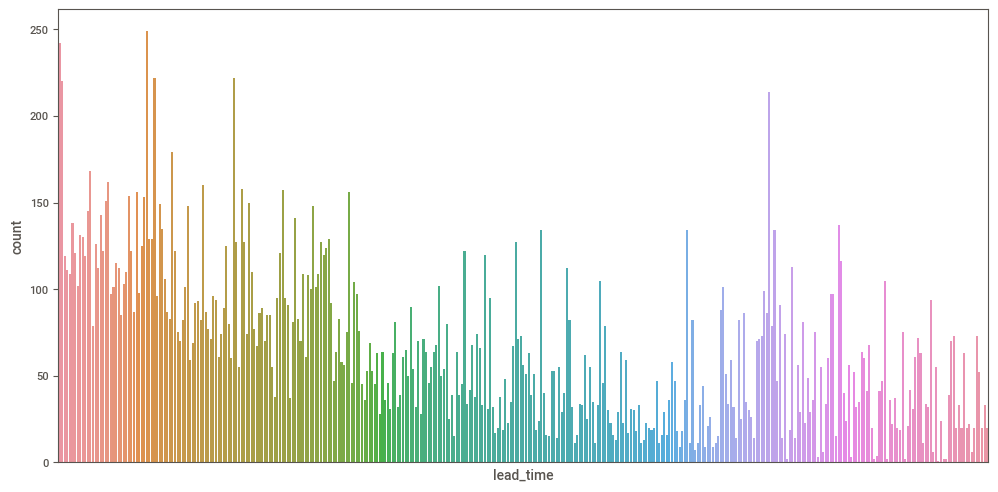

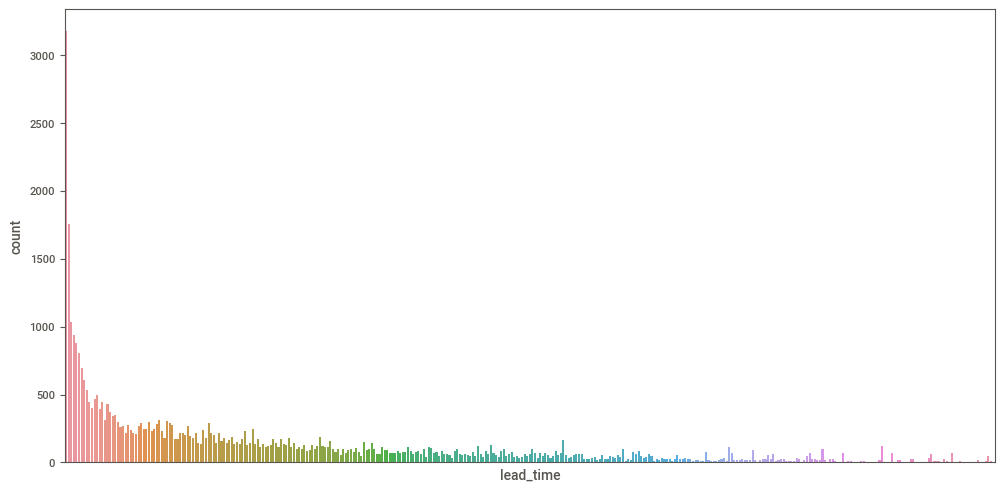

In [133]:
# рассмотрение распределения признака
feature_distribution_canceled(df_train, 'lead_time')
plt.xticks([])
feature_distribution_not_canceled(df_train, 'lead_time')
plt.xticks([])
print(f'Распределeние признака lead_time')

В среднем клиенты, подтвердившие бронирование, планируют свои поездки заранее, т.е. между датой бронирования и датой заезда бóльший интервал времени нежели у клиентов, не подтвердивших бронирование.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Распределeние признака total_of_special_requests


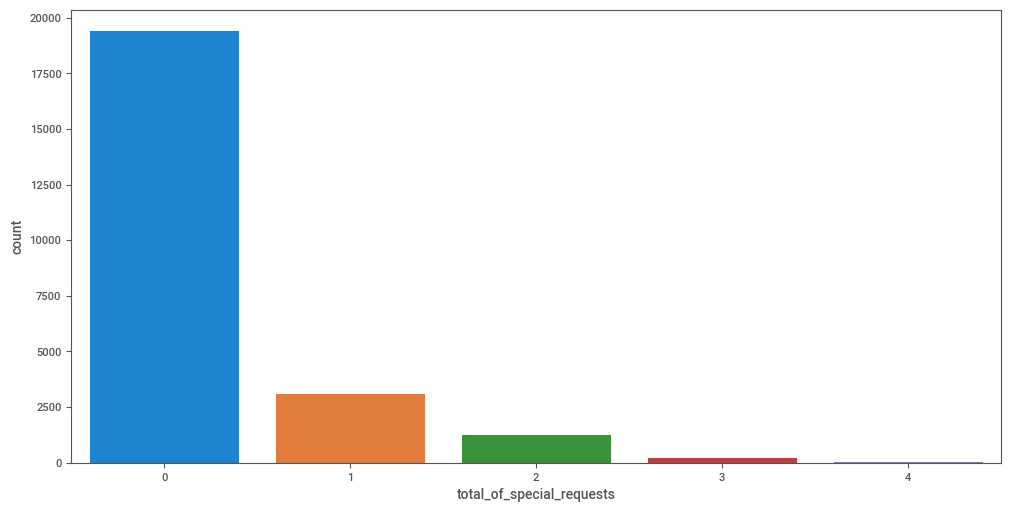

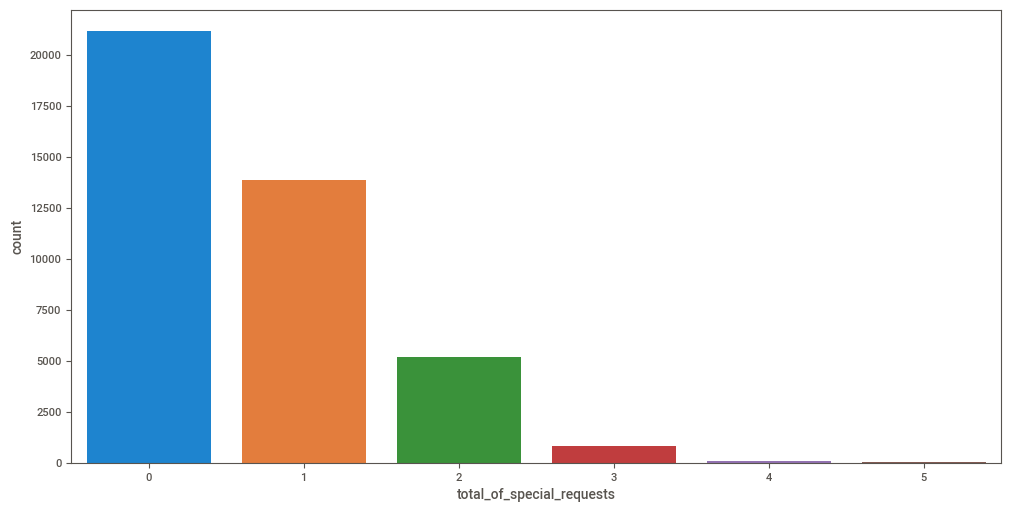

In [134]:
# рассмотрение распределения признака
feature_distribution_canceled(df_train, 'total_of_special_requests')
feature_distribution_not_canceled(df_train, 'total_of_special_requests')
print(f'Распределeние признака total_of_special_requests')

Из диаграммы распределения видим, что клиенты, подтвердившие бронирование, делают больше специальных запросов.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Распределeние признака required_car_parking_spaces


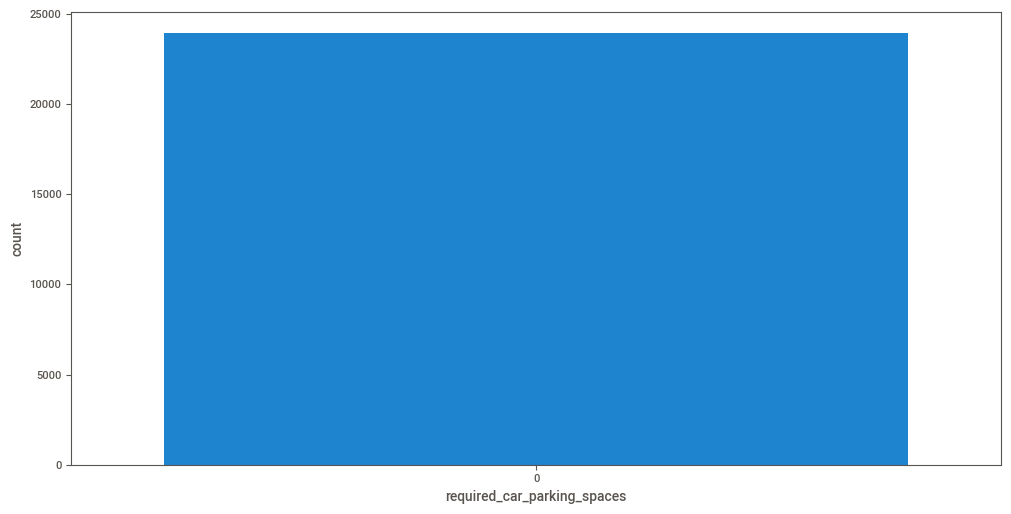

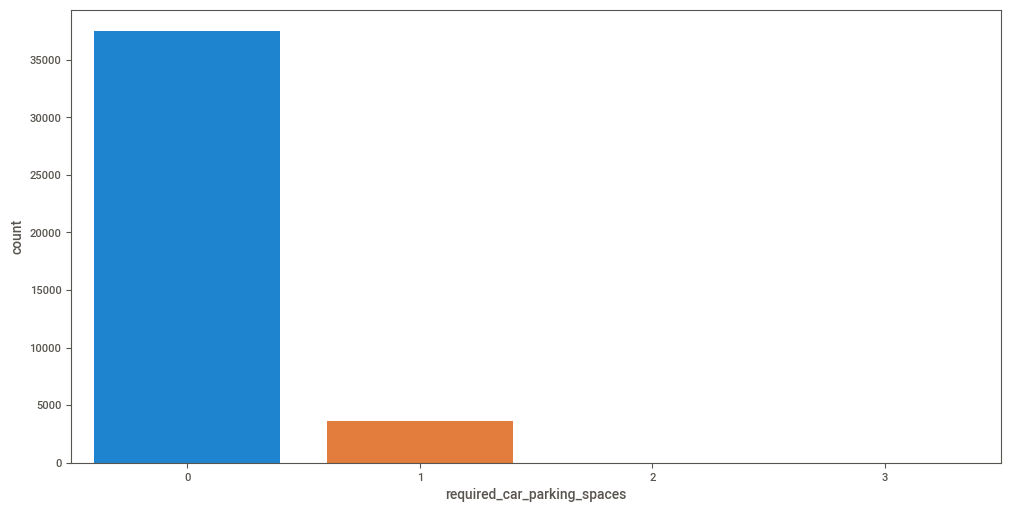

In [135]:
# рассмотрение распределения признака
feature_distribution_canceled(df_train, 'required_car_parking_spaces')
feature_distribution_not_canceled(df_train, 'required_car_parking_spaces')
print(f'Распределeние признака required_car_parking_spaces')

На графике чётко отражено следующее: клиенты, не подтвердившие бронирование, не запрашивают парковочные места. Среди клиентов, подтвердивших бронирование, имеется небольшая часть тех, кому требуются парковочные места.

**Вывод:**

Проанализированы признаки, оказывающие значительное влияние на прогнозирование. Рассмотрены распределения этих признаков.

Рассмотрев распределения, можем сделать следующий вывод: как правило, `ненадёжный клиент` клиент заранее не бронирует номер в отеле, он не запрашивает парковочные места и не делает «специальных отметок» при бронировании, т.е. не имеет особенных пожеланий.

### Шаг 6. Общий вывод

В результате исследования отобрана (при помощи метода кросс-валидации) наиболее высокая по качеству модель  — **модель решающего дерева, обученная с использованием техники `downsampling`(с этой техникой модель показала наиболее высокий результат на тестовой выборке)**. Целевая метрика качества *F1-score* доведена до достаточно высокого значения в **0.62**.

При подсчёте прибыли отеля обнаружено следующее: прибыль отеля вырастет на **55%** при внедрении системы прогнозирования и депозитов. Затраты на разработку модели окупятся в течение первого года функционирования системы.
